In [1]:
# Setup

library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



### Pfizer

         
            Neg   Pos
  Placebo 17349   162
  Vaccine 17403     8

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 05:52:46 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 34922
   Unobserved stochastic nodes: 2
   Total graph size: 69850
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.007905760,0.0092392250,0.010708200,0.0092521946,0.0007194355,NA,3.673594e-06,0.5,38353,0.005425482,1.000009
theta[2],0.000166714,0.0004424725,0.000782147,0.0004613858,0.0001634558,NA,8.120130e-07,0.5,40520,-0.002429383,1.000065


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                               
            Lower95     Median    Upper95       Mean         SD Mode      MCerr
theta[1]  0.0078587   0.009236   0.010682  0.0092495 0.00072253   -- 2.5545e-06
theta[2] 0.00017311 0.00044204 0.00078714 0.00046107   0.000163   -- 5.7829e-07
                                        
         MC%ofSD SSeff      AC.10   psrf
theta[1]     0.4 80000  0.0054255 1.0001
theta[2]     0.4 79449 -0.0024294      1

Total time taken: 1.7 minutes


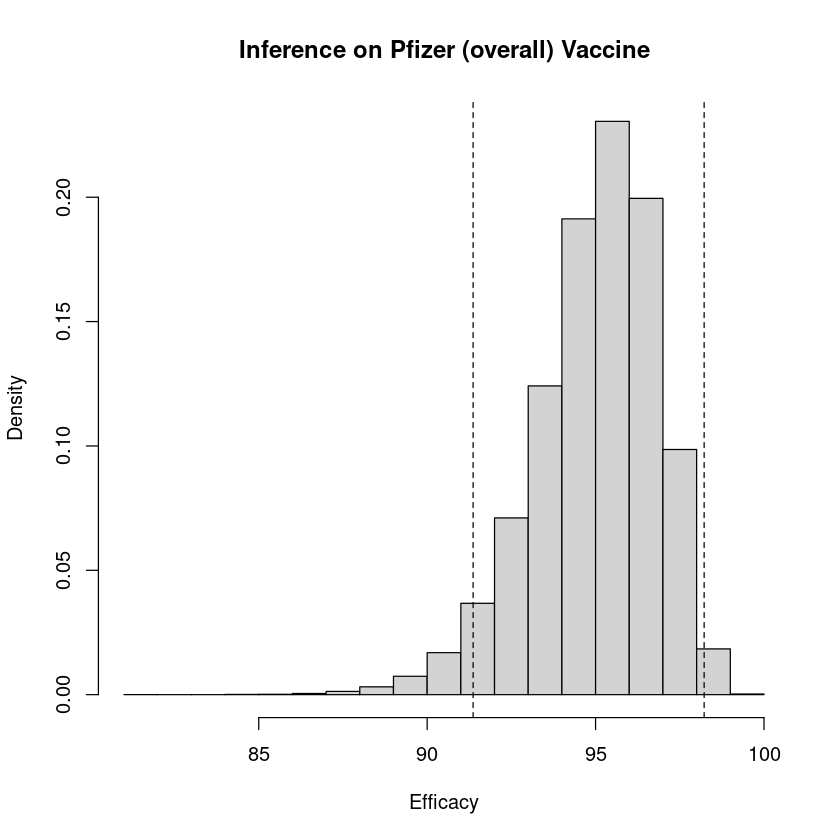

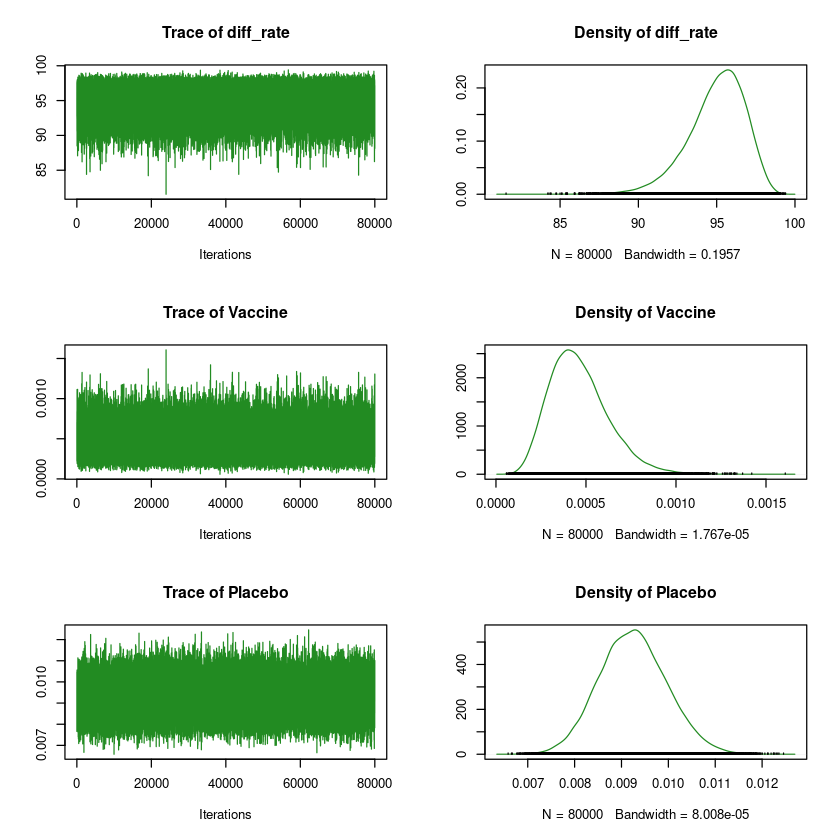

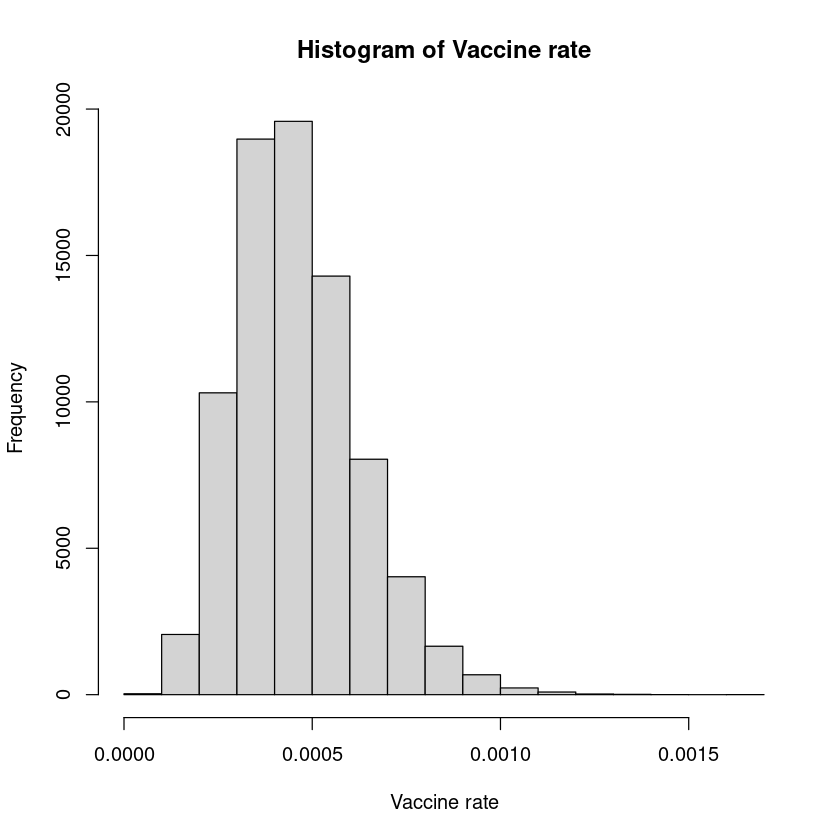

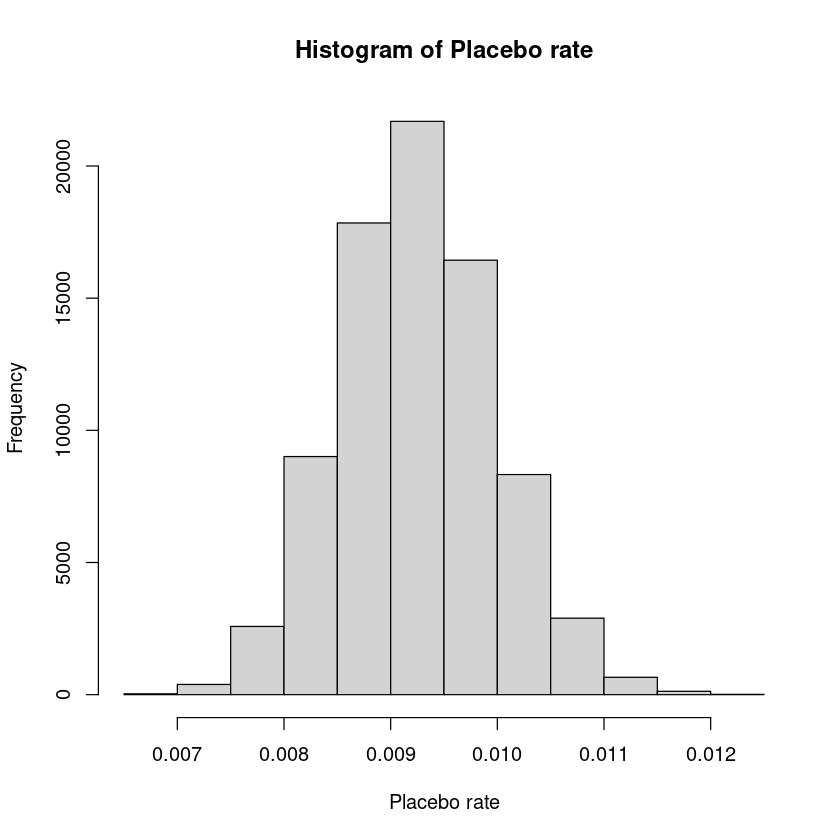

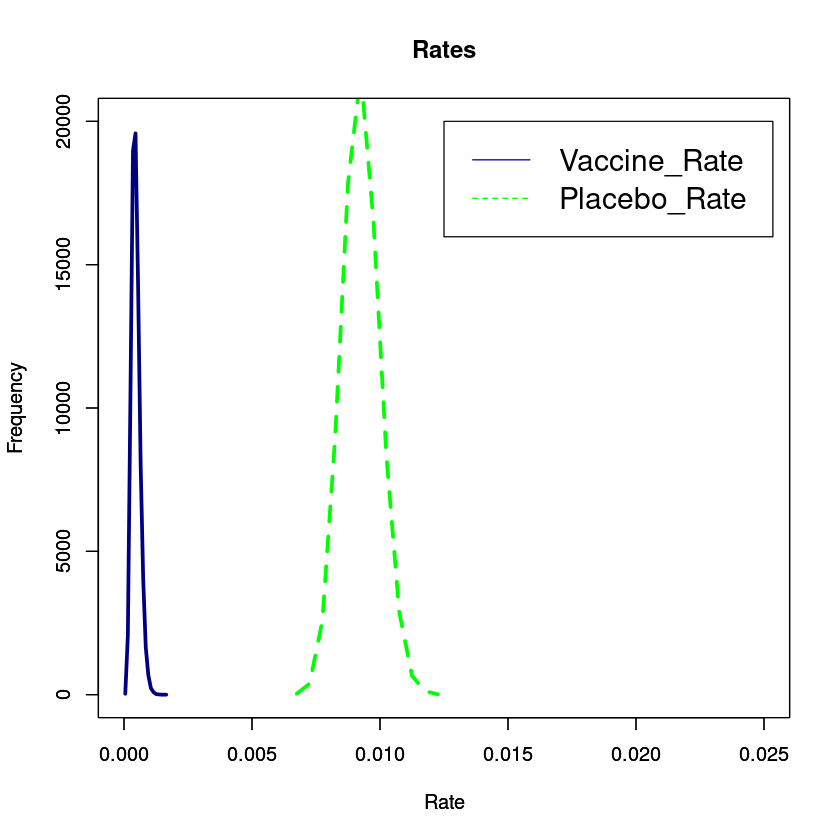

In [2]:
### overall


tot_vaccine <- 17411
tot_placebo <- 17511
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 8
pos_placebo <- 162
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)
tb= bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Pfizer(overall)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (overall) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()

#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
            Neg   Pos
  Placebo 13475   143
  Vaccine 13542     7

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 05:55:32 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 27167
   Unobserved stochastic nodes: 2
   Total graph size: 54340
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.008803250,0.010475600,0.012196300,0.0104957051,0.0008728485,NA,4.364242e-06,0.5,40000,0.0007156136,1.000030
theta[2],0.000163248,0.000491712,0.000896747,0.0005164366,0.0001962788,NA,9.764243e-07,0.5,40408,0.0017427823,1.000013


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                              
            Lower95     Median   Upper95       Mean         SD Mode      MCerr
theta[1]  0.0088073   0.010477  0.012226   0.010497 0.00087639   --  3.109e-06
theta[2] 0.00016238 0.00049273 0.0008963 0.00051698  0.0001956   -- 6.9154e-07
                                      
         MC%ofSD SSeff      AC.10 psrf
theta[1]     0.4 79464 0.00071561    1
theta[2]     0.4 80000  0.0017428    1

Total time taken: 1.4 minutes


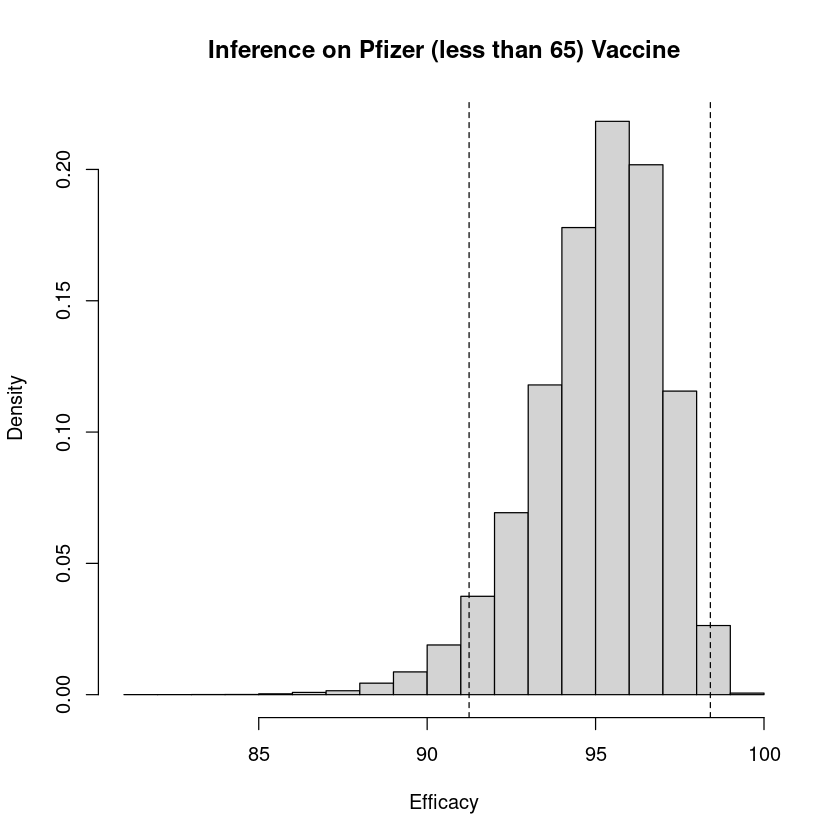

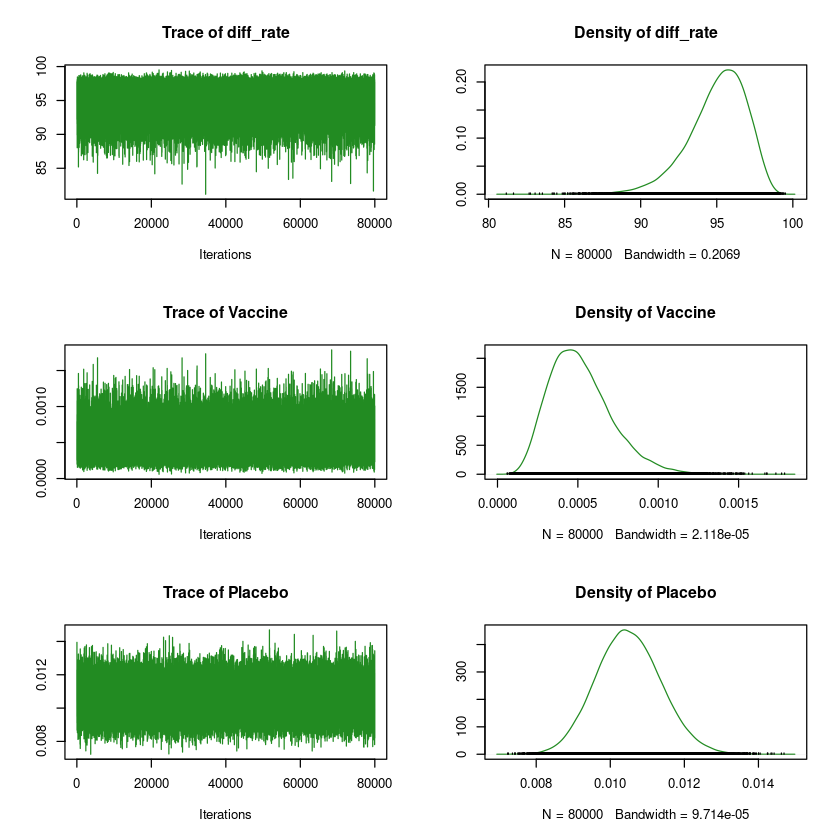

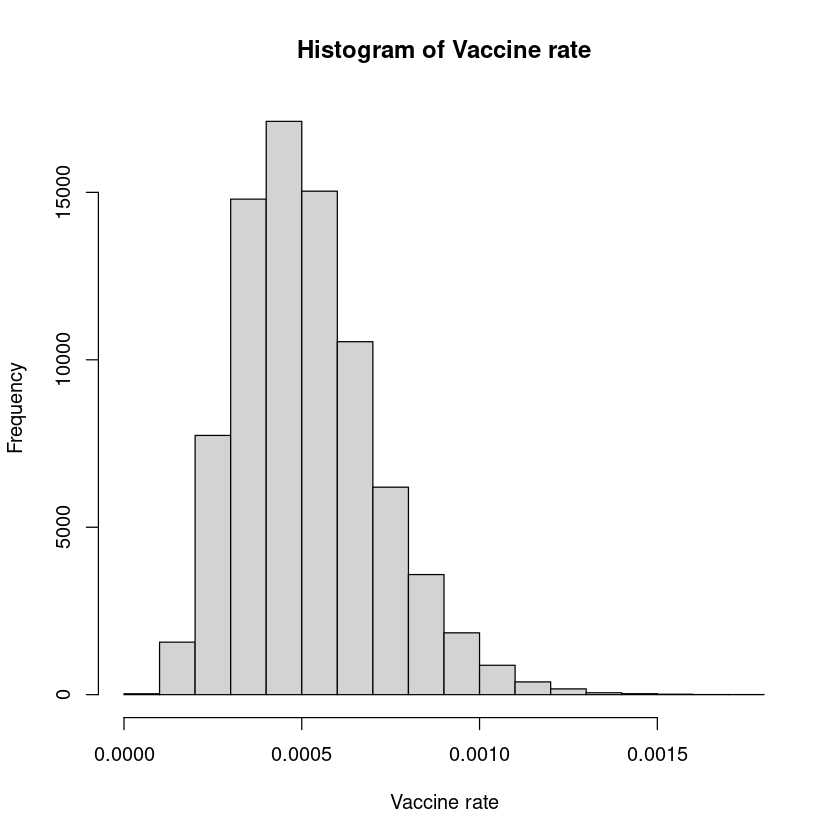

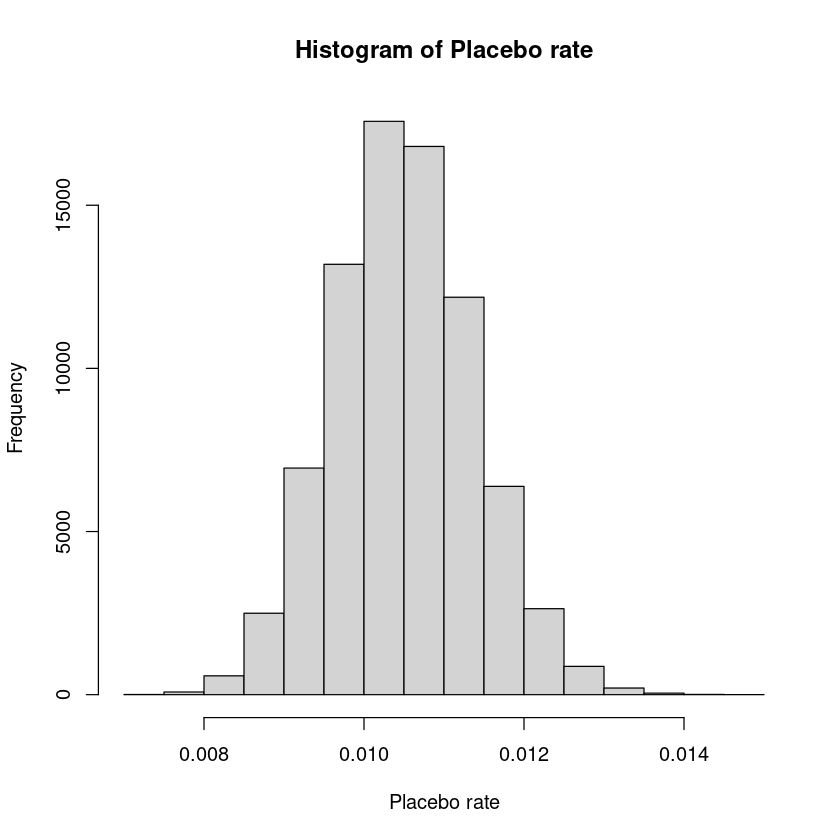

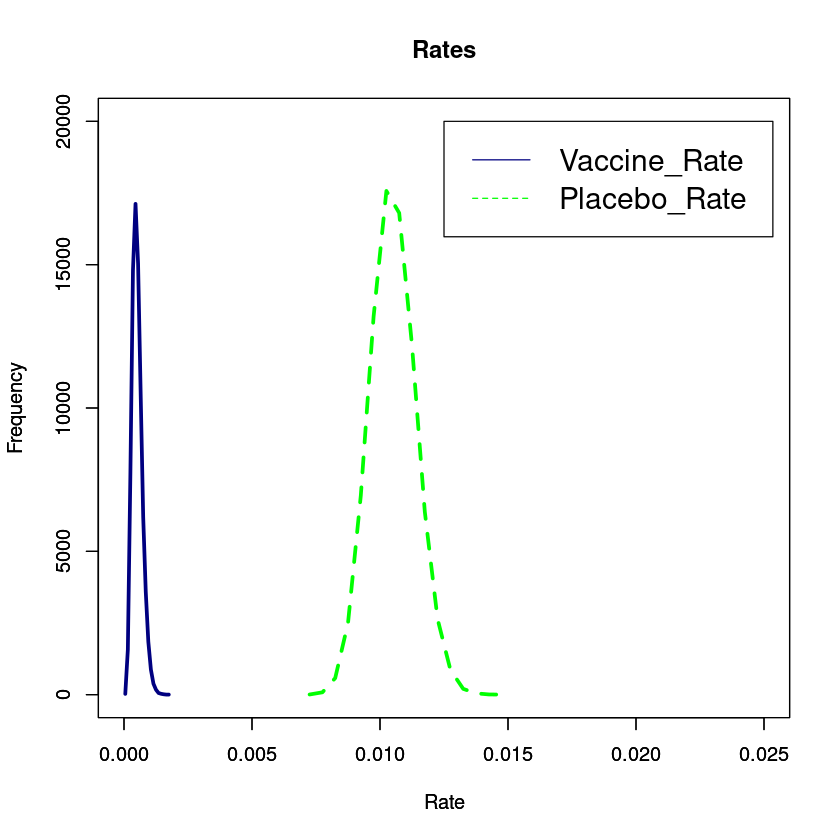

In [3]:
### less than 65


tot_vaccine <- 13549
tot_placebo <- 13618
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 7
pos_placebo <- 143
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)
tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                                    ci=0.95,
                                    test=c("p_direction"),
                                    centrality="map")


#pdf(file='Pfizer(less than 65)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (less than 65) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
           Neg  Pos
  Placebo 3861   19
  Vaccine 3847    1

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 05:59:22 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7728
   Unobserved stochastic nodes: 2
   Total graph size: 15462
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not re

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],2.91368e-03,0.004944035,0.00724337,0.0050207559,0.0011155587,NA,5.504420e-06,0.5,41074,-0.001524252,1.0000996
theta[2],1.02675e-05,0.000429254,0.00120155,0.0005082108,0.0003562587,NA,1.788366e-06,0.5,39684,0.003081677,0.9999755


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                               
             Lower95     Median   Upper95       Mean         SD Mode      MCerr
theta[1]   0.0029061  0.0049426 0.0072456  0.0050238  0.0011223   -- 3.9335e-06
theta[2] 0.000010204 0.00042628 0.0012025 0.00050652 0.00035682   -- 1.2616e-06
                                        
         MC%ofSD SSeff      AC.10   psrf
theta[1]     0.4 81413 -0.0015243 1.0001
theta[2]     0.4 80000  0.0030817      1

Total time taken: 21.1 seconds


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,94.9309,0.95,73.8379,99.80037,1


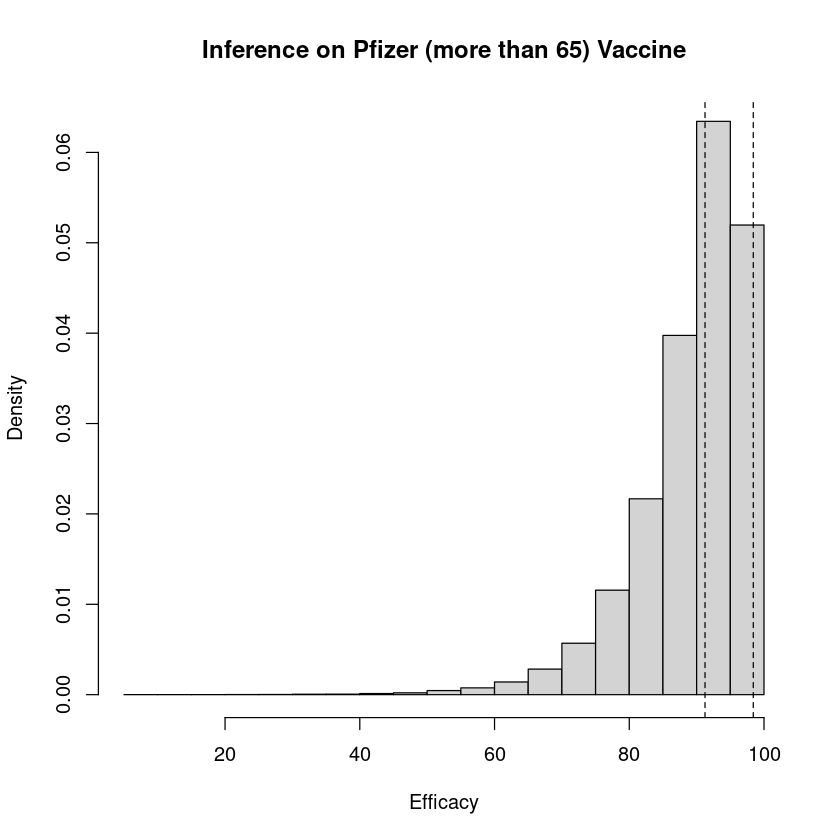

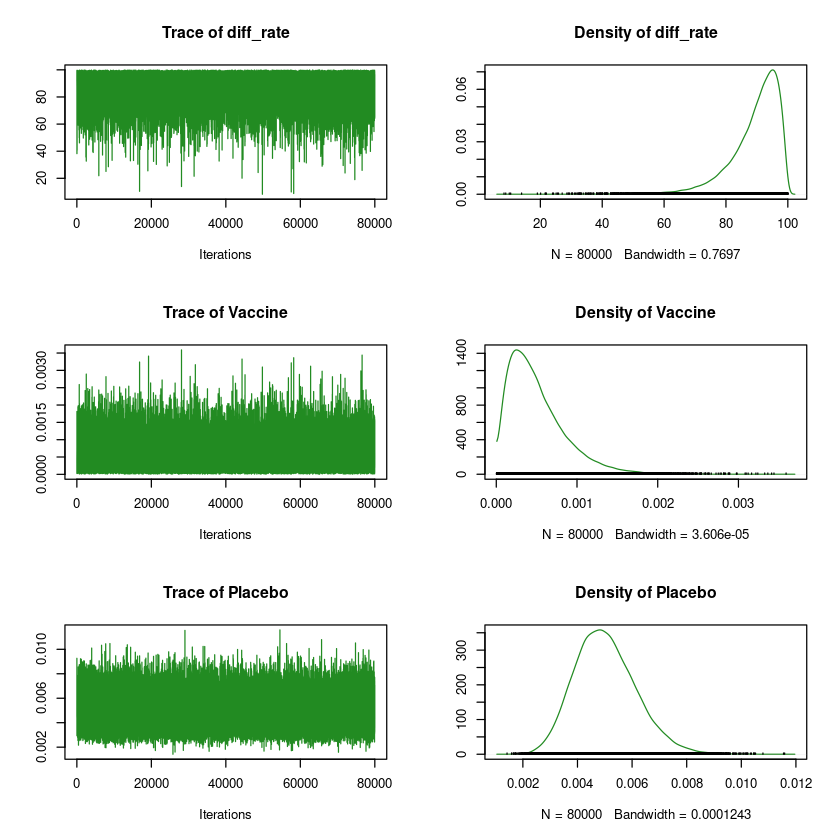

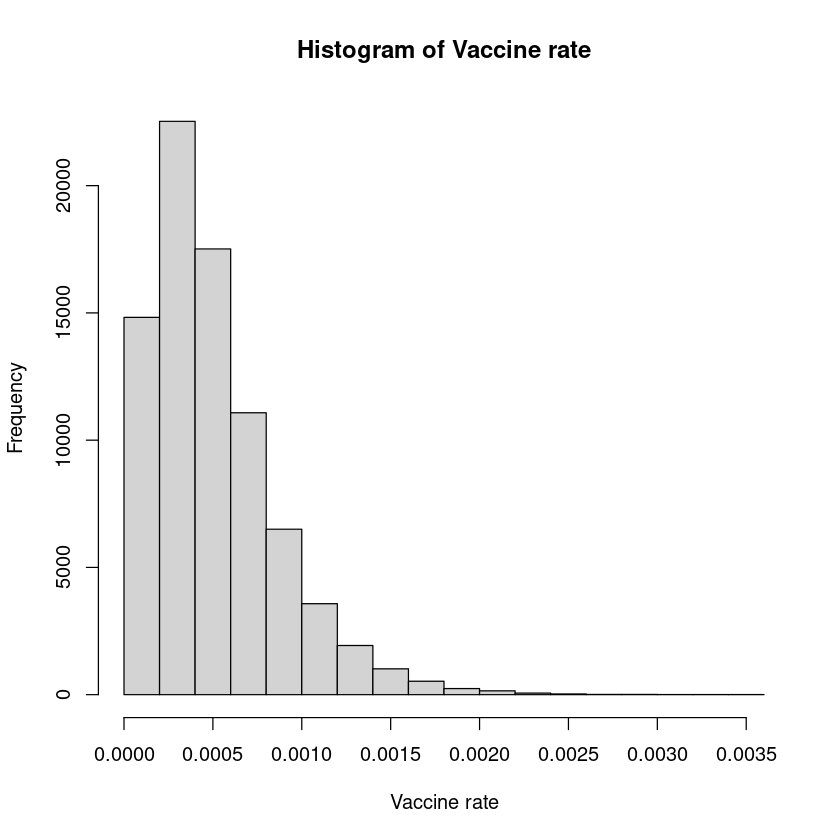

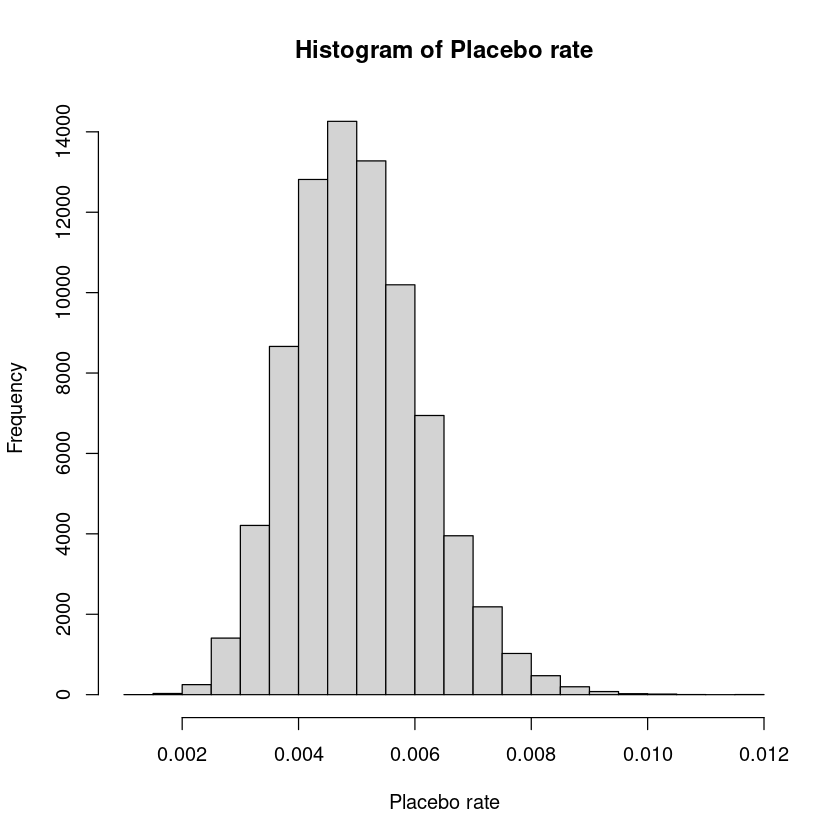

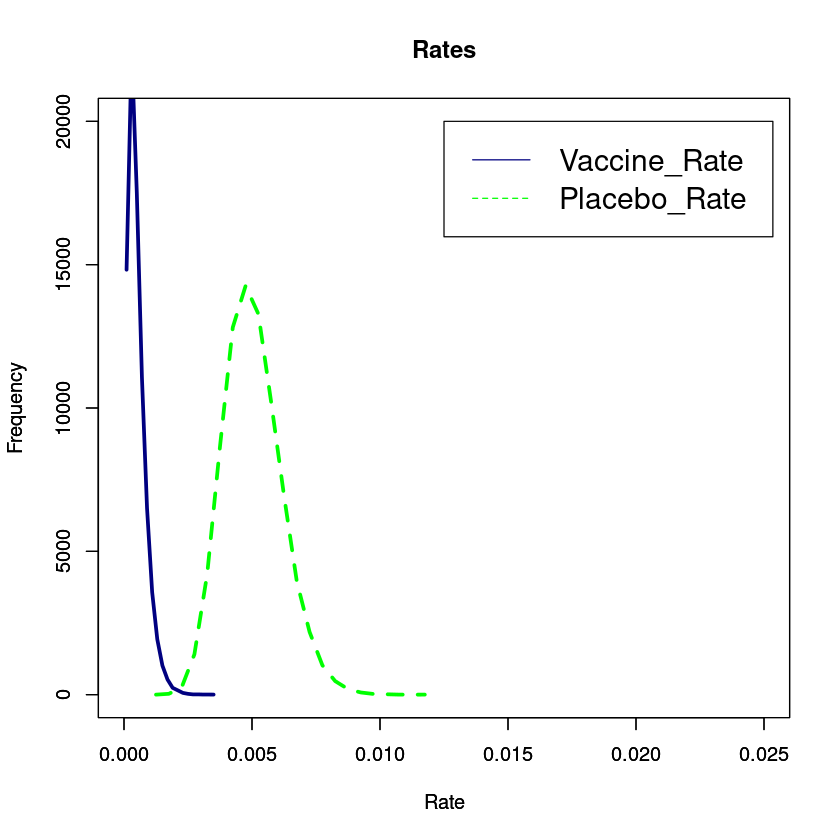

In [5]:
### more than 65


tot_vaccine <- 3848
tot_placebo <- 3880
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 1
pos_placebo <- 19
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(1 , 100)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_elder_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (more than 65) Vaccine')

bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

#pdf(file='Pfizer(more than 65)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (more than 65) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
           Neg  Pos
  Placebo 3081   14
  Vaccine 3073    1

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:00:52 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 6169
   Unobserved stochastic nodes: 2
   Total graph size: 12344
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not re

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],2.43860e-03,0.0045971100,0.00707564,0.0046958321,0.0012087322,NA,6.014513e-06,0.5,40389,0.003243683,1.000137
theta[2],9.28909e-06,0.0005290605,0.00149557,0.0006285622,0.0004465924,NA,2.221316e-06,0.5,40421,-0.001257641,1.000020


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                               
             Lower95     Median   Upper95       Mean         SD Mode      MCerr
theta[1]   0.0024585  0.0045969 0.0070865  0.0046971  0.0012067   -- 4.2662e-06
theta[2] 0.000011987 0.00052979 0.0015023 0.00063073 0.00044717   --  1.581e-06
                                        
         MC%ofSD SSeff      AC.10   psrf
theta[1]     0.4 80000  0.0032437 1.0001
theta[2]     0.4 80000 -0.0012576      1

Total time taken: 12.4 seconds


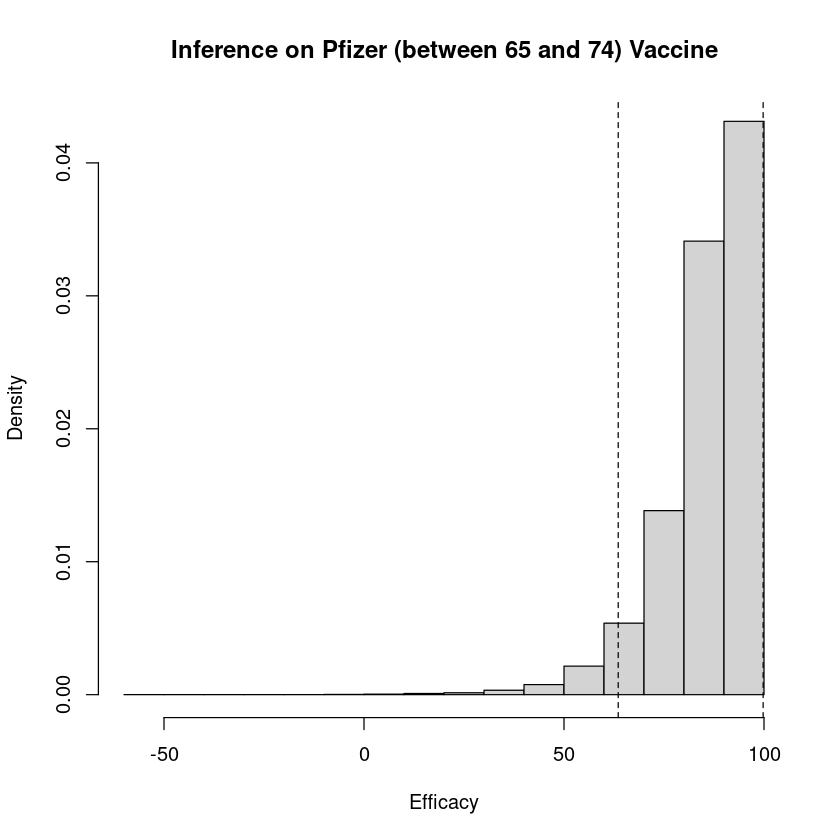

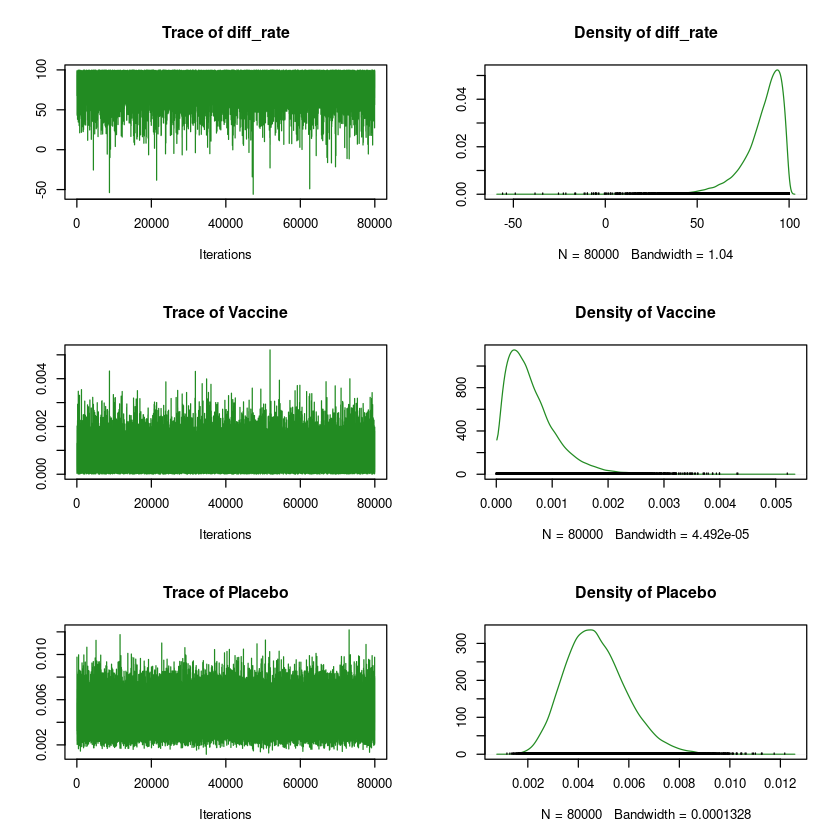

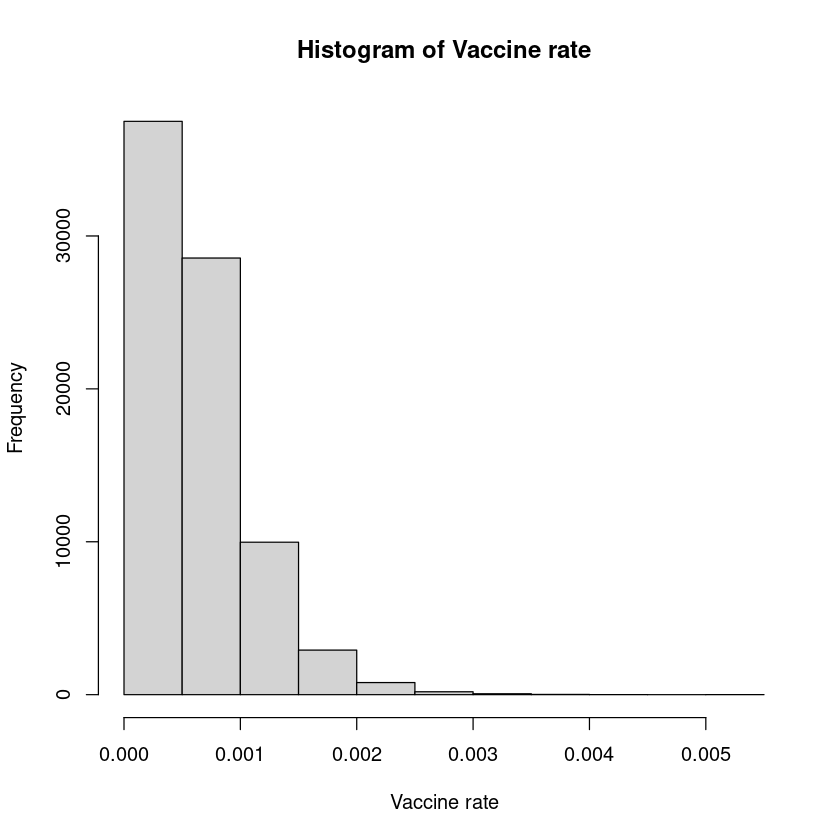

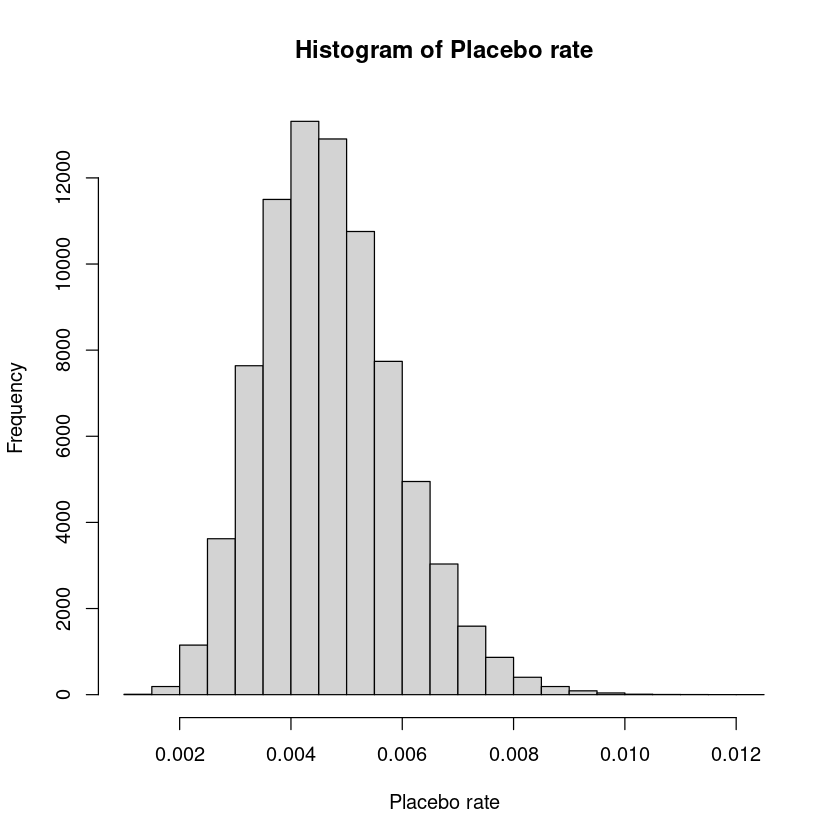

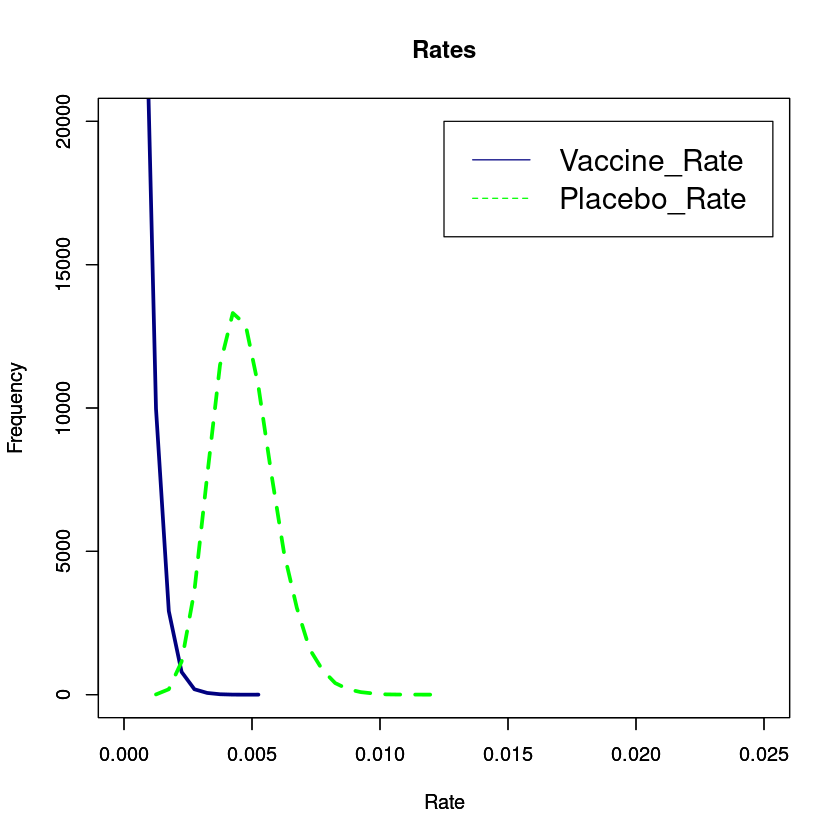

In [6]:
### between 65 and 74


tot_vaccine <- 3074
tot_placebo <- 3095
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 1
pos_placebo <- 14
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(1 , 100)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_elder_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)
tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Pfizer(between 65 and 74)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (between 65 and 74) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
          Neg Pos
  Placebo 780   5
  Vaccine 774   0

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:02:05 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1559
   Unobserved stochastic nodes: 2
   Total graph size: 3124
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not req

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],1.63948e-03,5.971155e-03,1.20940e-02,6.381147e-03,0.0028351883,NA,1.411187e-05,0.5,40364,0.001778065,1.000088
theta[2],5.61887e-311,1.191480e-33,5.30968e-06,1.382904e-05,0.0001317314,NA,6.586572e-07,0.5,40000,-0.002827921,1.000028


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                    
             Lower95     Median    Upper95      Mean         SD Mode
theta[1]   0.0014959  0.0059484   0.011911 0.0063679  0.0028375   --
theta[2] 5.6189e-311 7.0717e-34 4.5976e-06 0.0000134 0.00013259   --
                                                  
               MCerr MC%ofSD SSeff      AC.10 psrf
theta[1] 0.000010095     0.4 79010  0.0017781    1
theta[2]  4.7621e-07     0.4 77518 -0.0028279    1

Total time taken: 2.1 seconds


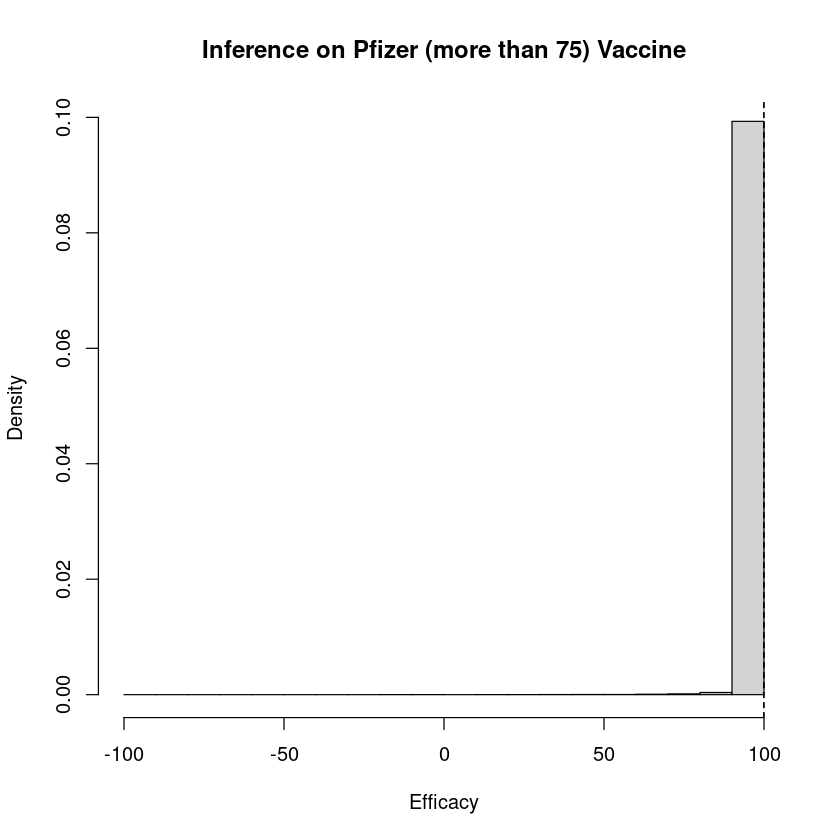

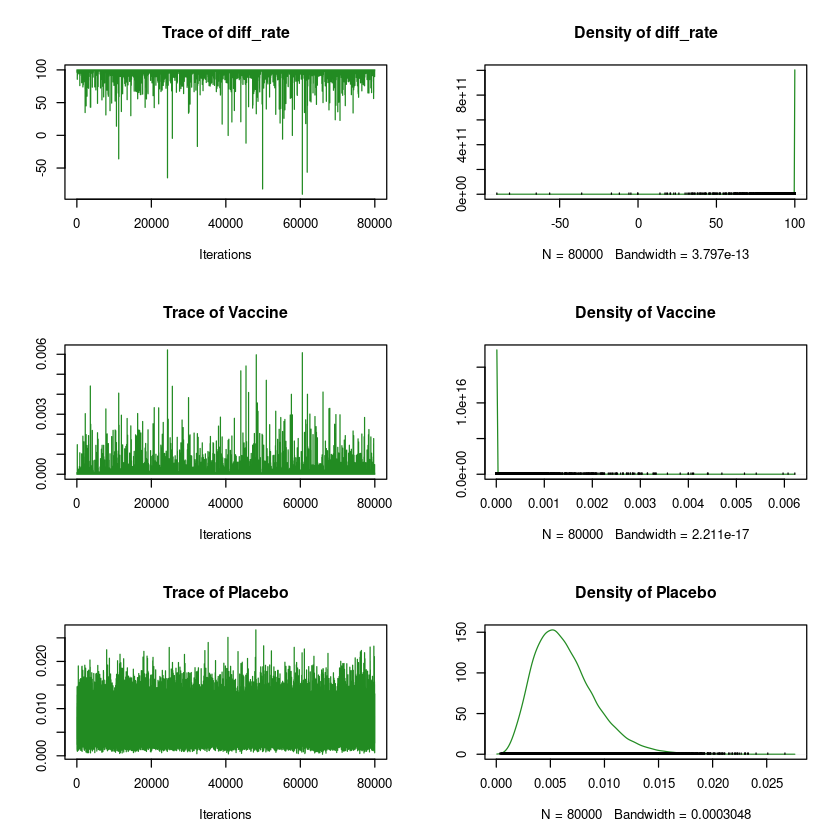

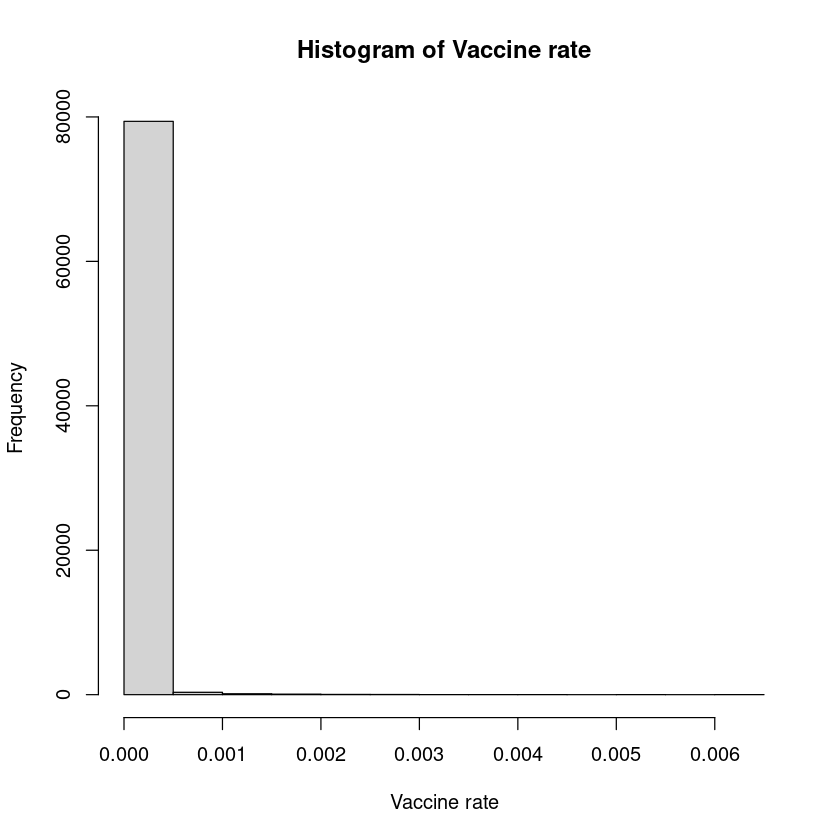

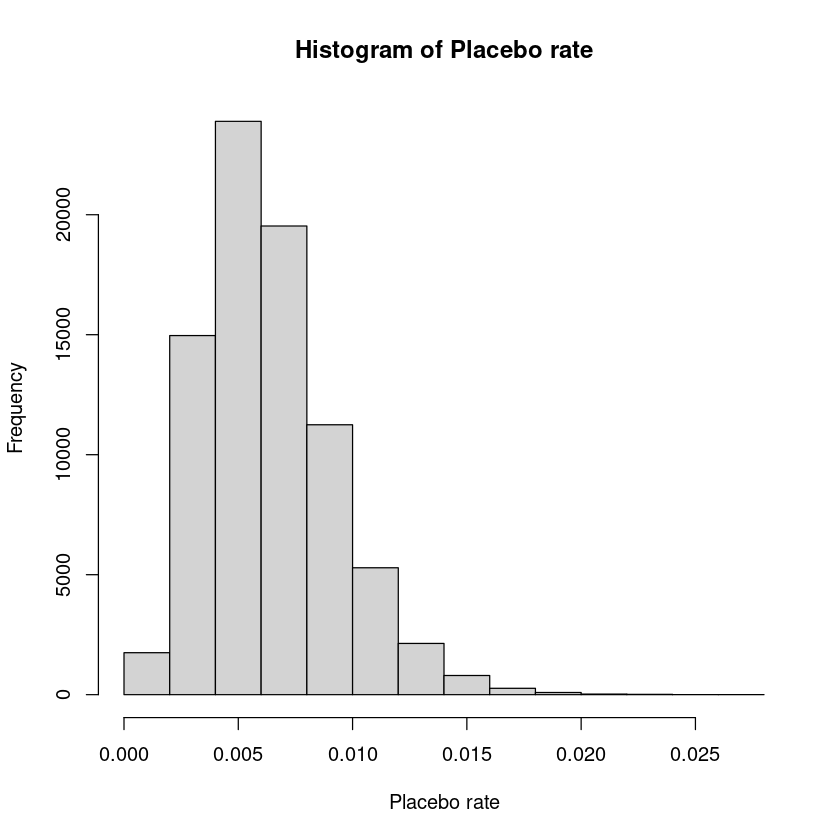

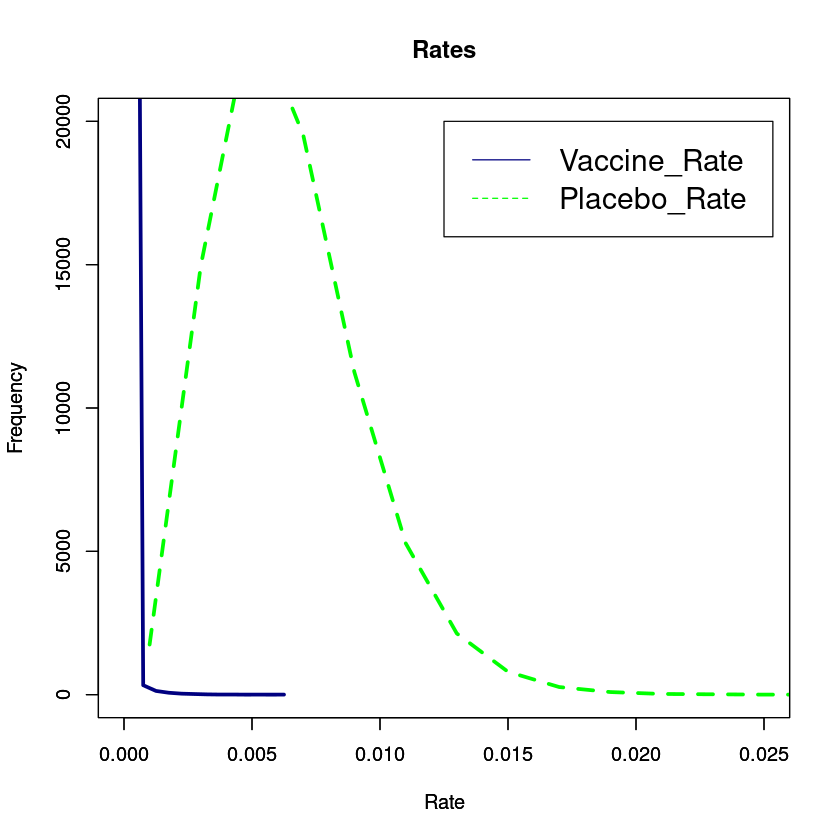

In [7]:
### more than 75


tot_vaccine <- 774
tot_placebo <- 785
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 0
pos_placebo <- 5
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#pdf(file='Pfizer')
#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (more than 75) Vaccine',xlab='Efficacy')
#dev.off()

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Pfizer(more than 75)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Pfizer (more than 75) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

### Moderna

         
            Neg   Pos
  Placebo 13888   185
  Vaccine 14123    11

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:02:54 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56420
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.011276400,0.01311560,0.01502330,0.0131439240,0.0009646922,NA,4.823461e-06,0.5,40000,0.006702514,1.000067
theta[2],0.000347155,0.00075686,0.00124932,0.0007812302,0.0002366872,NA,1.190432e-06,0.5,39531,-0.005231505,1.000026


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                              
            Lower95     Median   Upper95       Mean         SD Mode      MCerr
theta[1]   0.011266   0.013119  0.015027   0.013145 0.00096371   -- 3.3913e-06
theta[2] 0.00035009 0.00075595 0.0012501 0.00078009 0.00023635   -- 8.3809e-07
                                         
         MC%ofSD SSeff      AC.10    psrf
theta[1]     0.4 80753  0.0067025       1
theta[2]     0.4 79527 -0.0052315 0.99999

Total time taken: 1.5 minutes


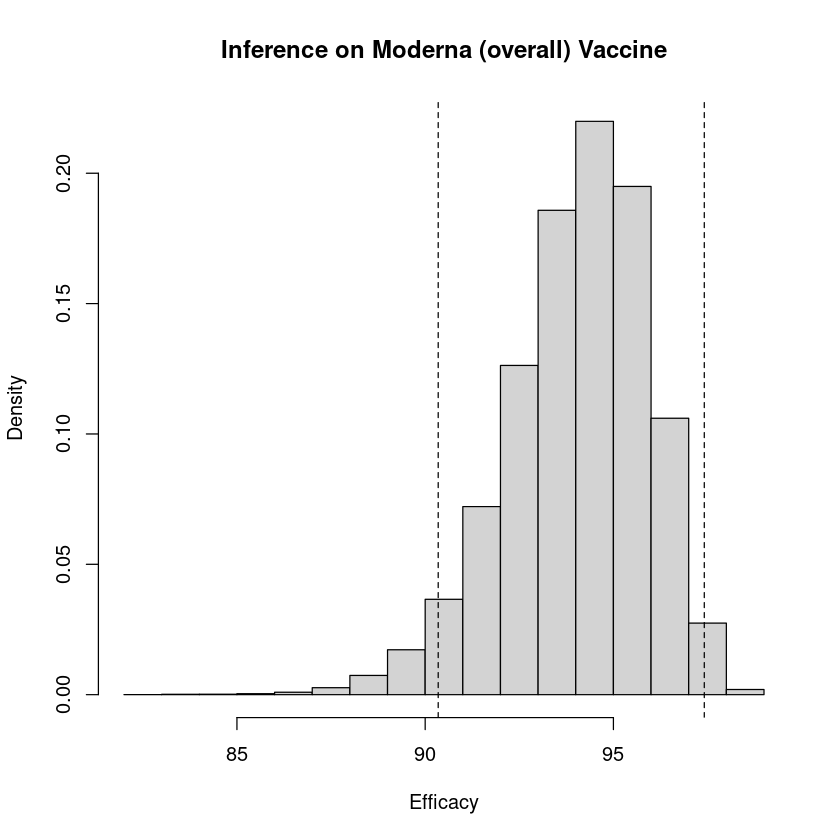

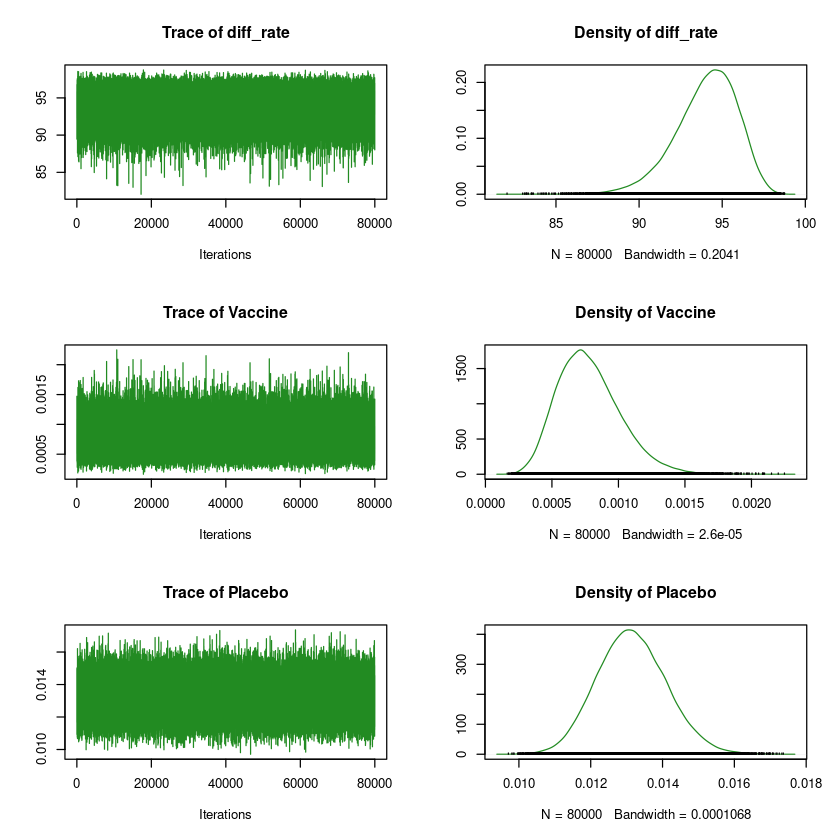

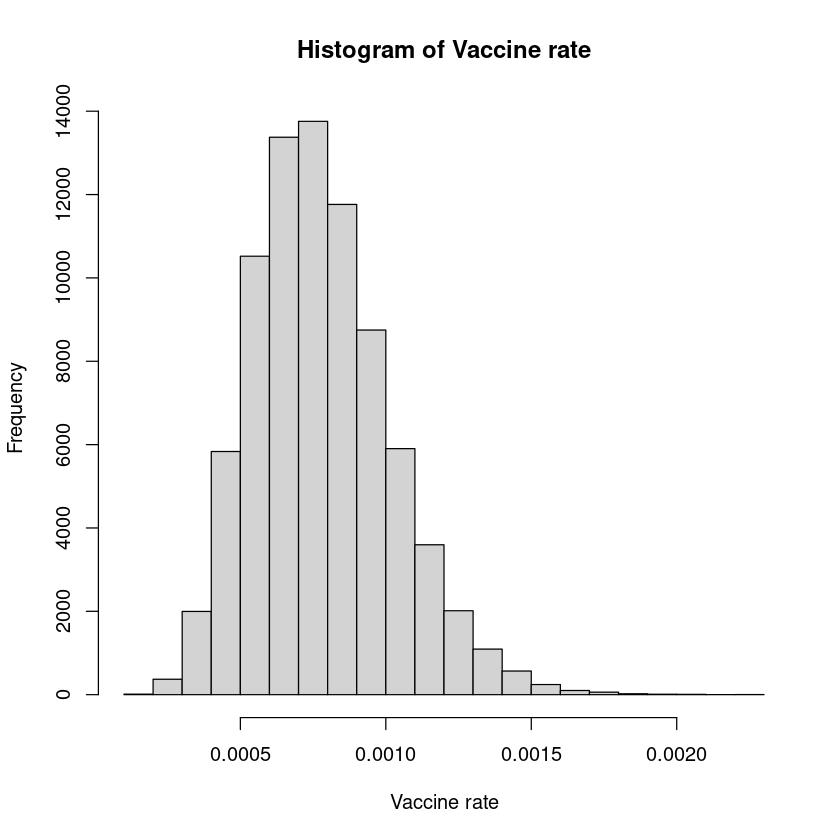

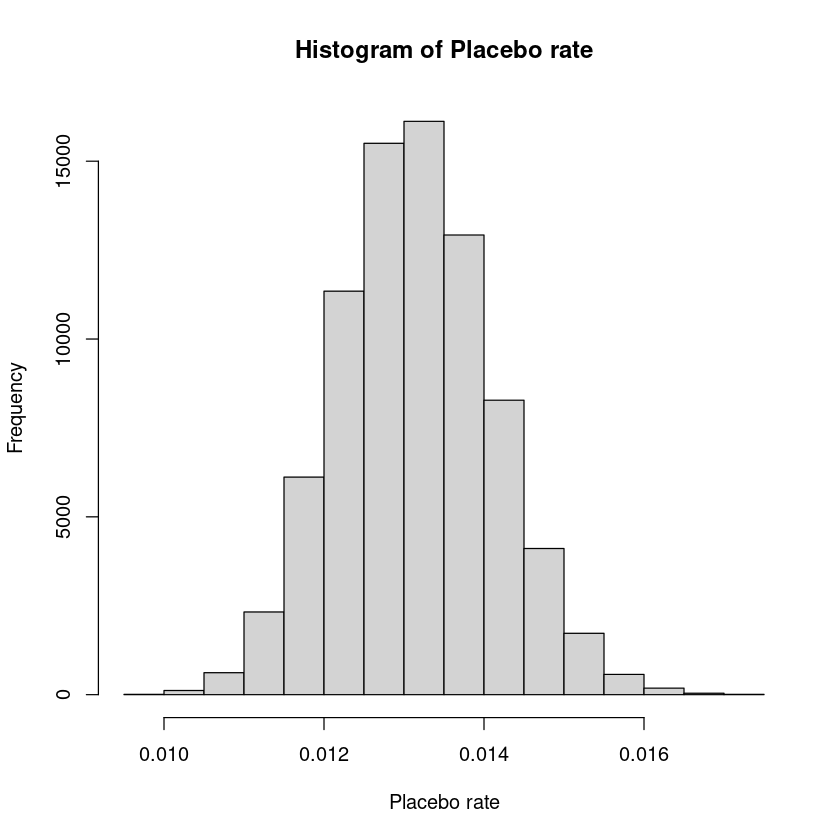

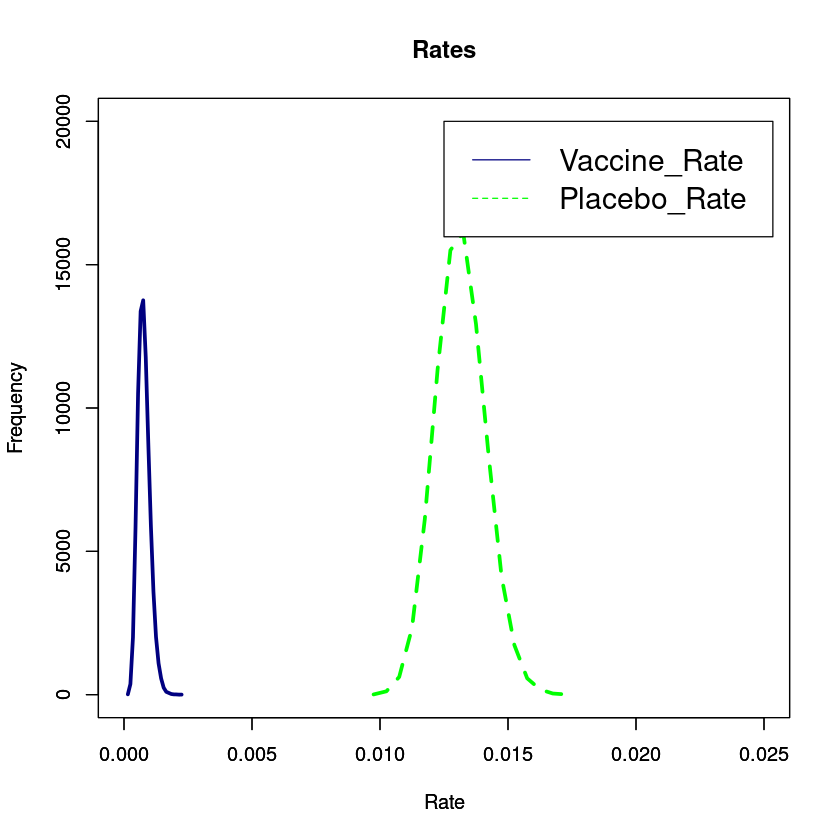

In [8]:
### overall


tot_vaccine <- 14134
tot_placebo <- 14073
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 11
pos_placebo <- 185
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (overall) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

#pdf(file='Moderna(overall)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (overall) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()



#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
            Neg   Pos
  Placebo 10365   156
  Vaccine 10544     7

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:05:10 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 21072
   Unobserved stochastic nodes: 2
   Total graph size: 42150
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.012511500,0.014786300,0.01711750,0.0148283937,0.0011756649,NA,5.881616e-06,0.5,39955,-0.001359008,0.9999786
theta[2],0.000226463,0.000632958,0.00117328,0.0006647306,0.0002515519,NA,1.257760e-06,0.5,40000,-0.001030142,1.0000498


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                             
            Lower95     Median   Upper95       Mean        SD Mode      MCerr
theta[1]    0.01257    0.01479  0.017153   0.014826 0.0011738   -- 4.1385e-06
theta[2] 0.00023091 0.00063336 0.0011733 0.00066392 0.0002508   -- 8.9042e-07
                                         
         MC%ofSD SSeff      AC.10    psrf
theta[1]     0.4 80446  -0.001359 0.99999
theta[2]     0.4 79334 -0.0010301       1

Total time taken: 1 minutes


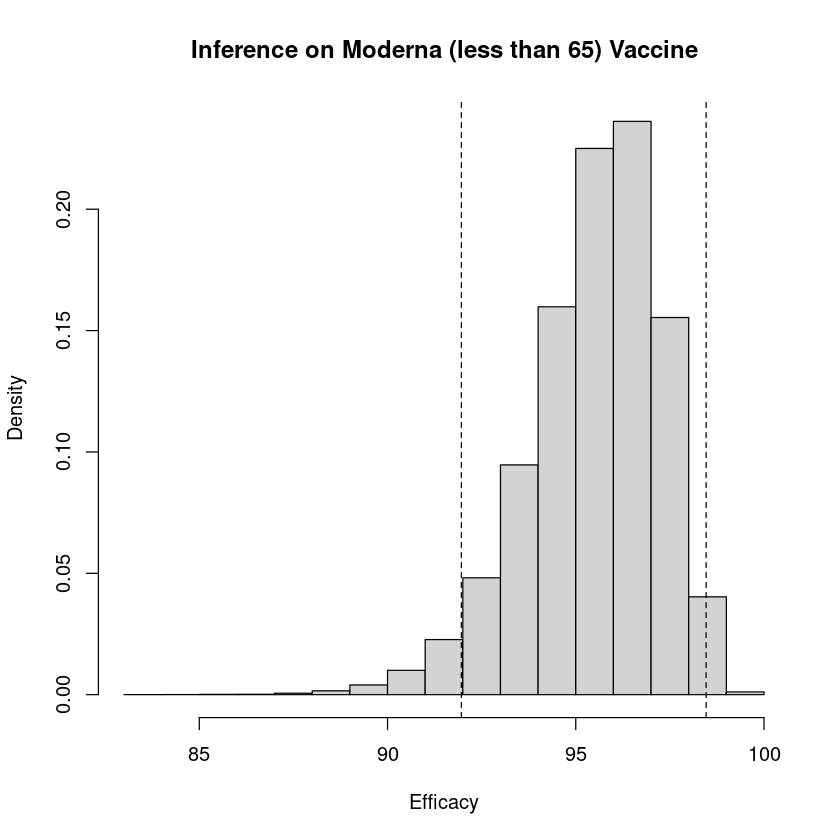

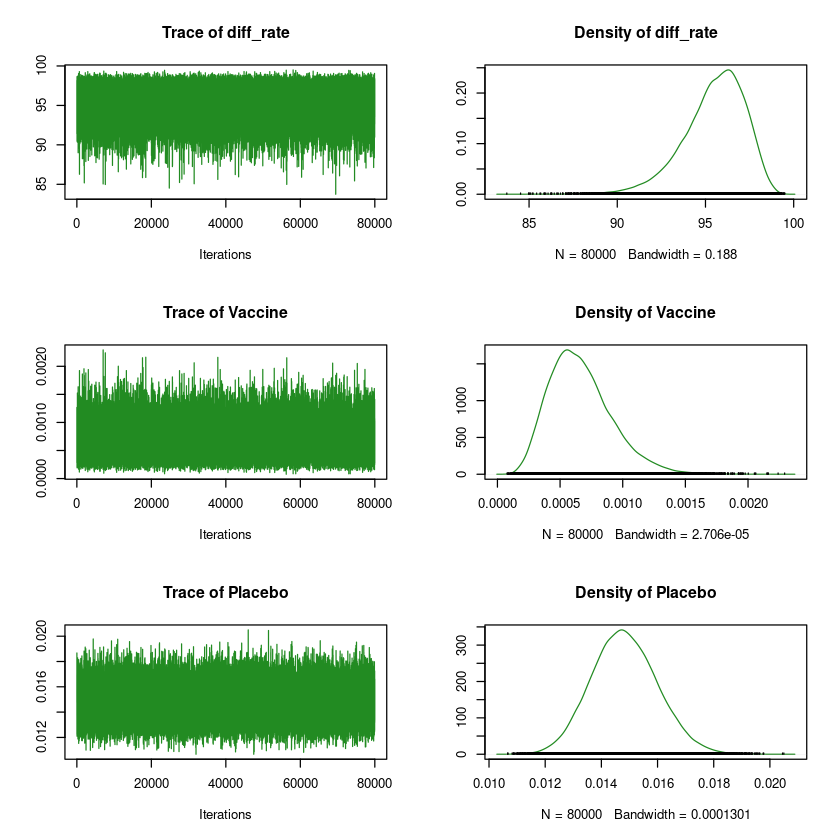

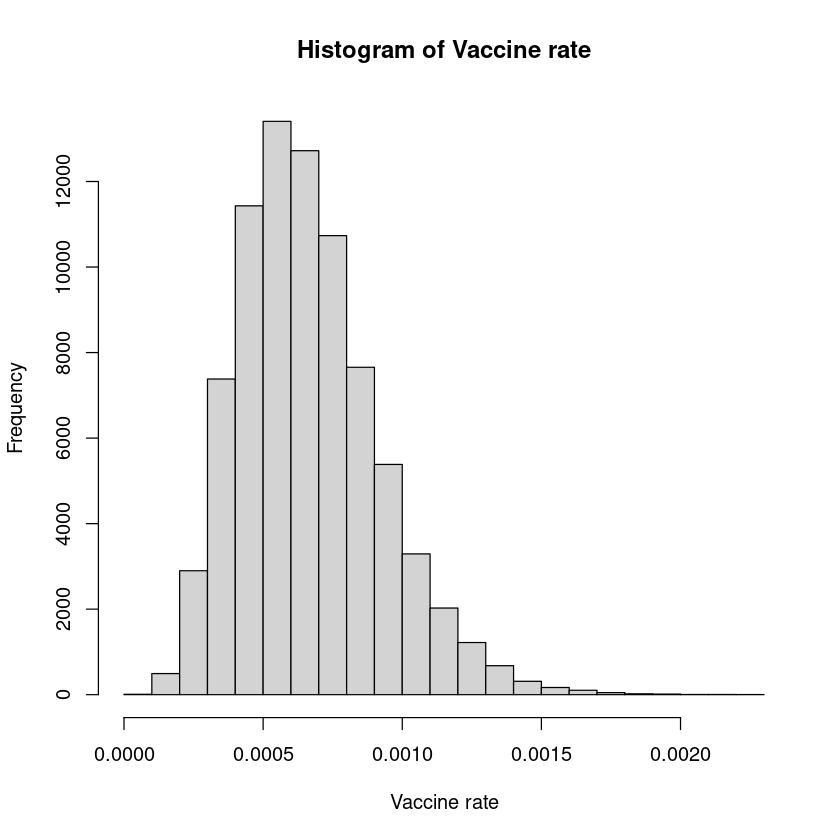

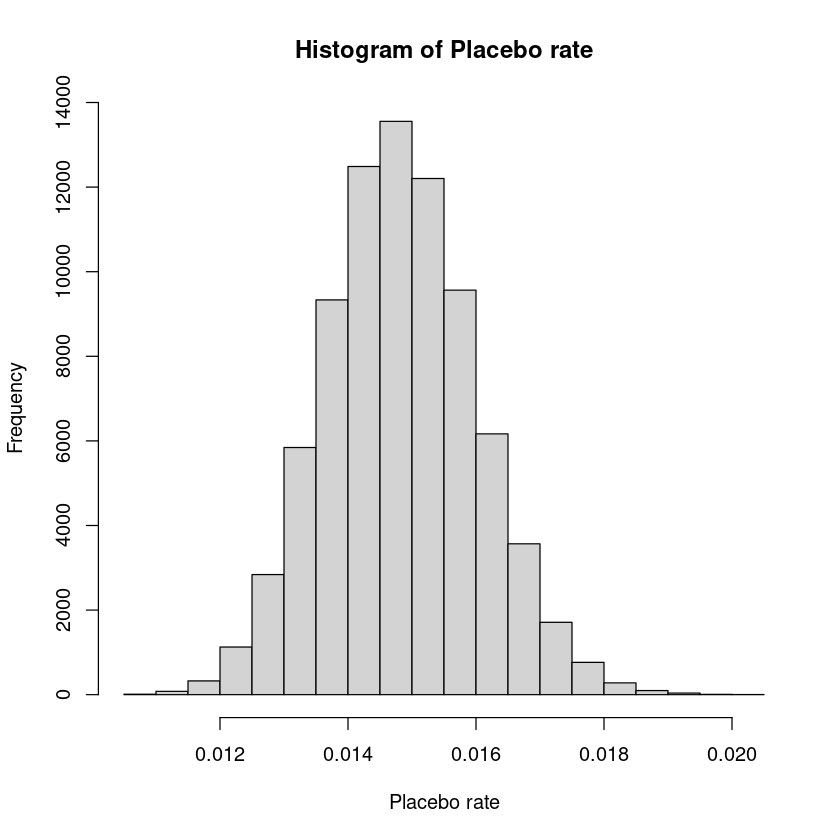

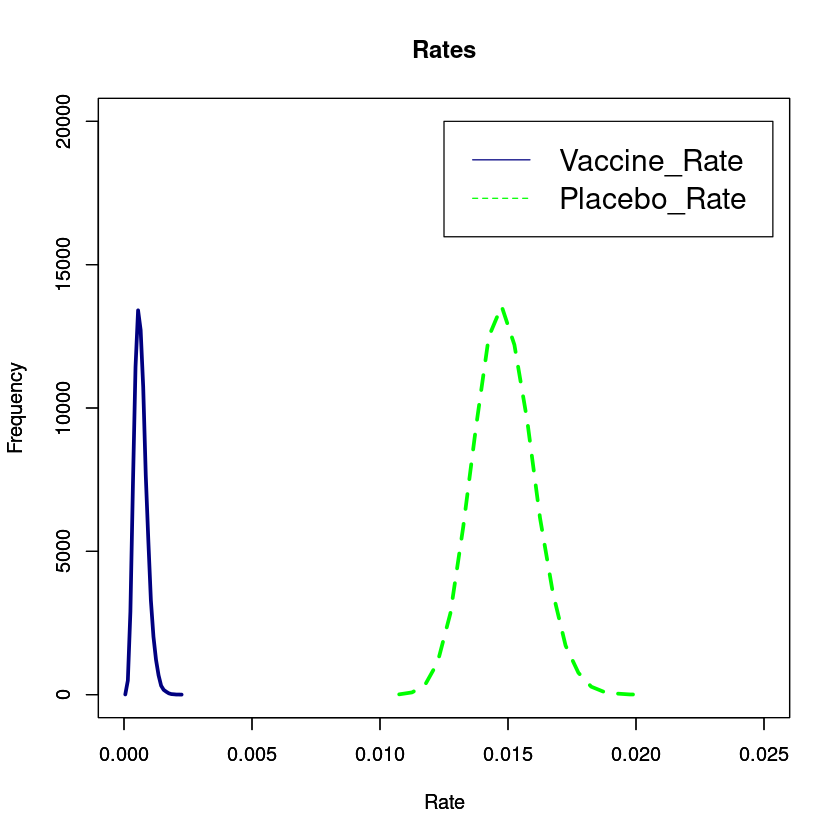

In [9]:
### less than 65


tot_vaccine <- 10551
tot_placebo <- 10521
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 7
pos_placebo <- 156
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (less than 65) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

#pdf(file='Moderna(less than 65)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (less than 65) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
           Neg  Pos
  Placebo 3523   29
  Vaccine 3579    4

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:06:50 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7135
   Unobserved stochastic nodes: 2
   Total graph size: 14276
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not re

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.005352760,0.008119065,0.01114400,0.008211509,0.0014873067,NA,7.410825e-06,0.5,40278,6.684421e-05,0.9999649
theta[2],0.000309508,0.001269690,0.00255287,0.001360618,0.0006095507,NA,3.047754e-06,0.5,40000,1.924438e-03,1.0000292


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
            Lower95    Median  Upper95      Mean         SD Mode      MCerr
theta[1]  0.0054142 0.0081152  0.01124 0.0082087  0.0014975   -- 5.2807e-06
theta[2] 0.00032507 0.0012698 0.002557 0.0013586 0.00060583   -- 2.1419e-06
                                          
         MC%ofSD SSeff       AC.10    psrf
theta[1]     0.4 80412 0.000066844 0.99999
theta[2]     0.4 80000   0.0019244       1

Total time taken: 22.7 seconds


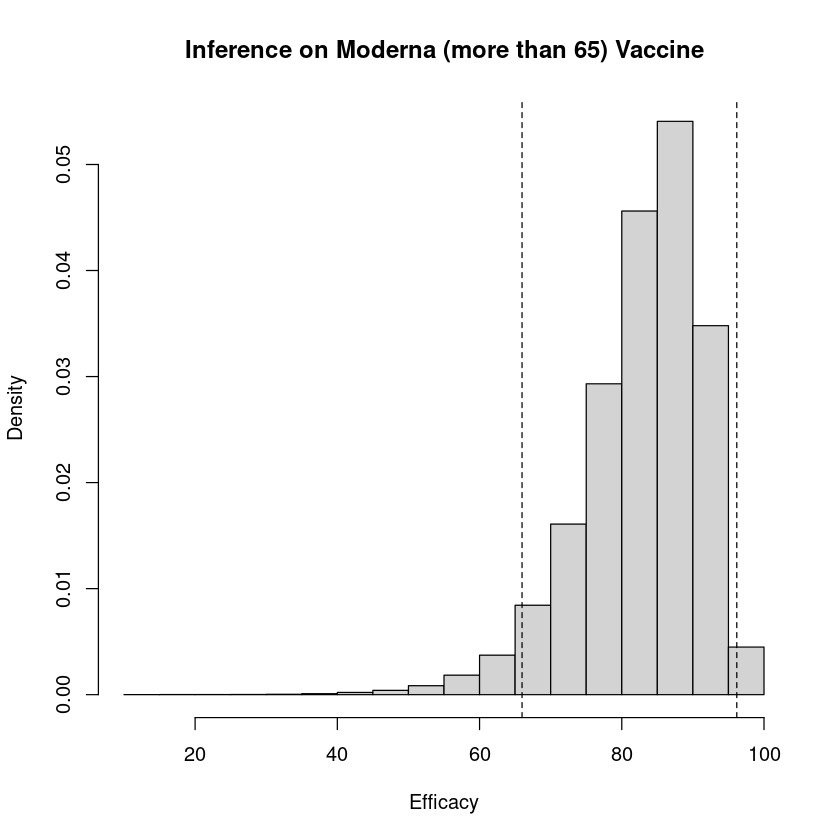

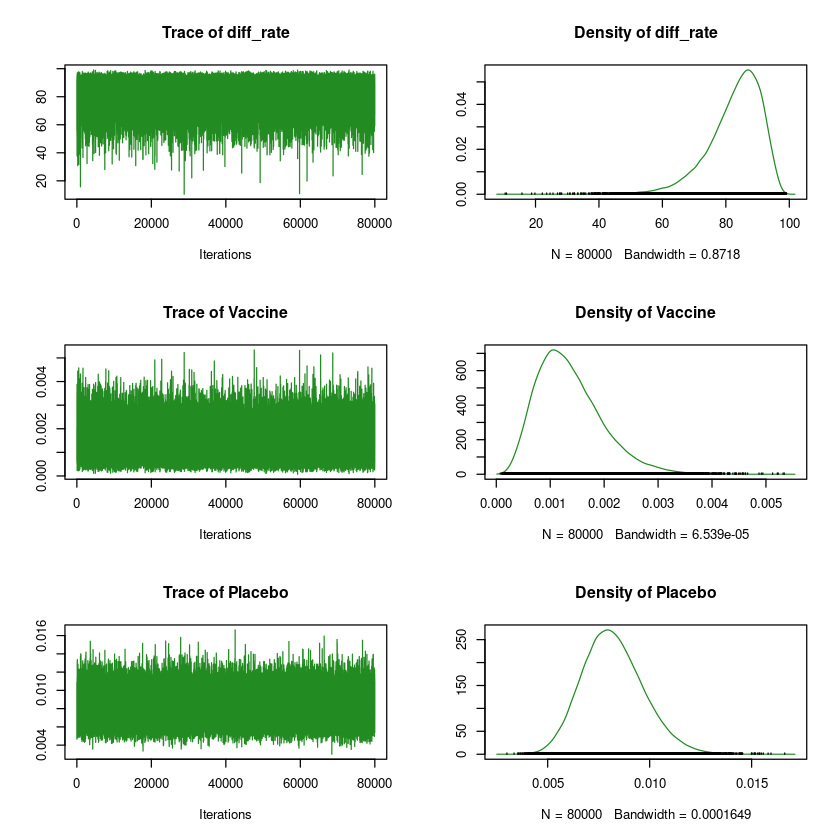

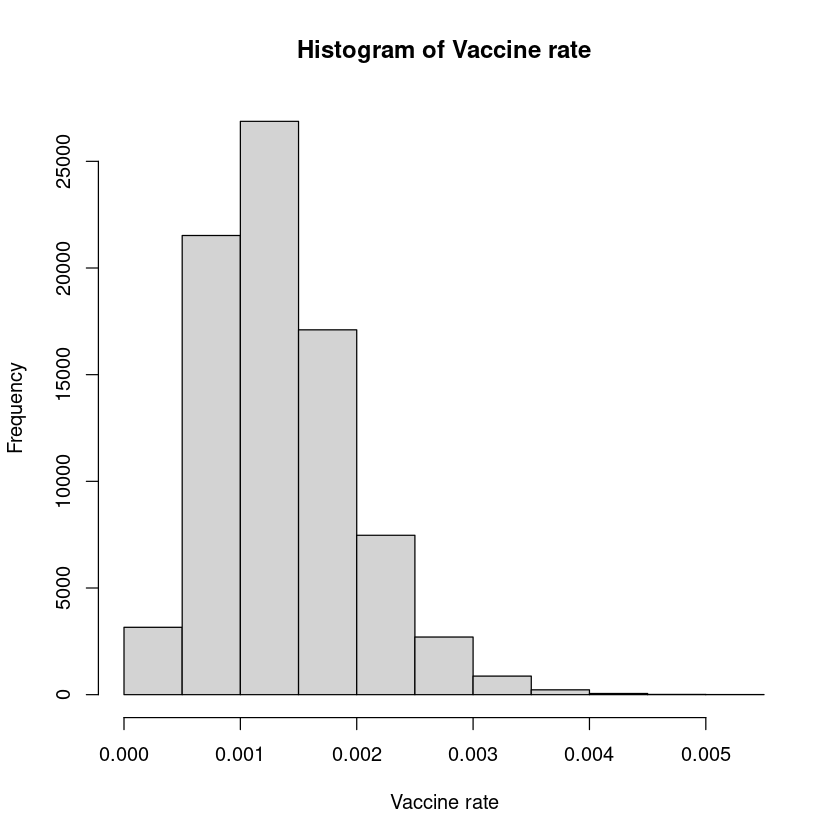

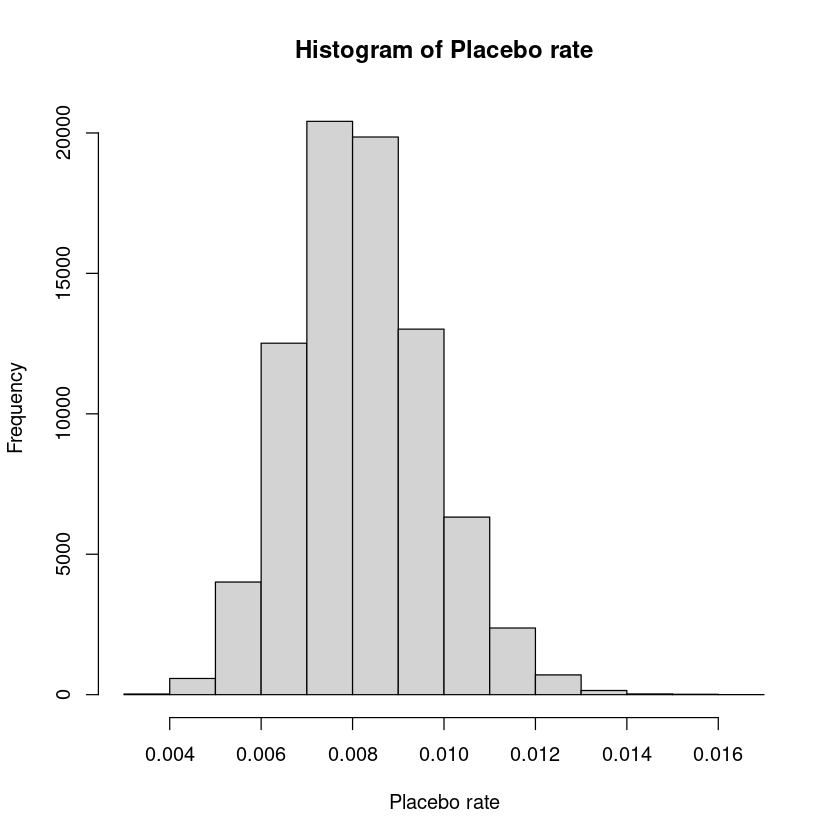

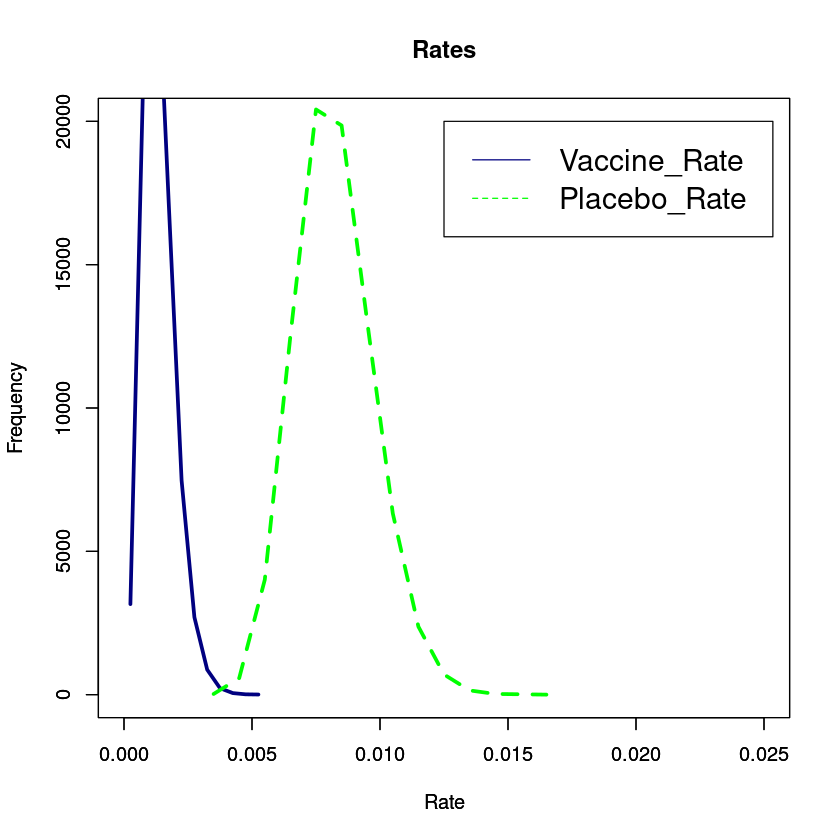

In [10]:
### more than 65


tot_vaccine <- 3583
tot_placebo <- 3552
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 4
pos_placebo <- 29
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(1 , 100)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_elder_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (more than 65) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

#pdf(file='Moderna(more than 65)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (more than 65) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
           Neg  Pos
  Placebo 2842   22
  Vaccine 2949    4

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:08:03 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 5817
   Unobserved stochastic nodes: 2
   Total graph size: 11640
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not re

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.004737210,0.007636115,0.01096040,0.007747250,0.0016078312,NA,8.039156e-06,0.5,40000,0.001777399,1.000017
theta[2],0.000386647,0.001526005,0.00306863,0.001635258,0.0007317416,NA,3.622554e-06,0.5,40802,0.002809984,1.000069


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1] 0.0047372 0.0076351  0.010963 0.0077494  0.0016101   -- 5.6927e-06
theta[2] 0.0003989 0.0015281 0.0030946 0.0016368 0.00073341   -- 2.5827e-06
                                       
         MC%ofSD SSeff     AC.10   psrf
theta[1]     0.4 80000 0.0017774      1
theta[2]     0.4 80641   0.00281 1.0001

Total time taken: 17.3 seconds


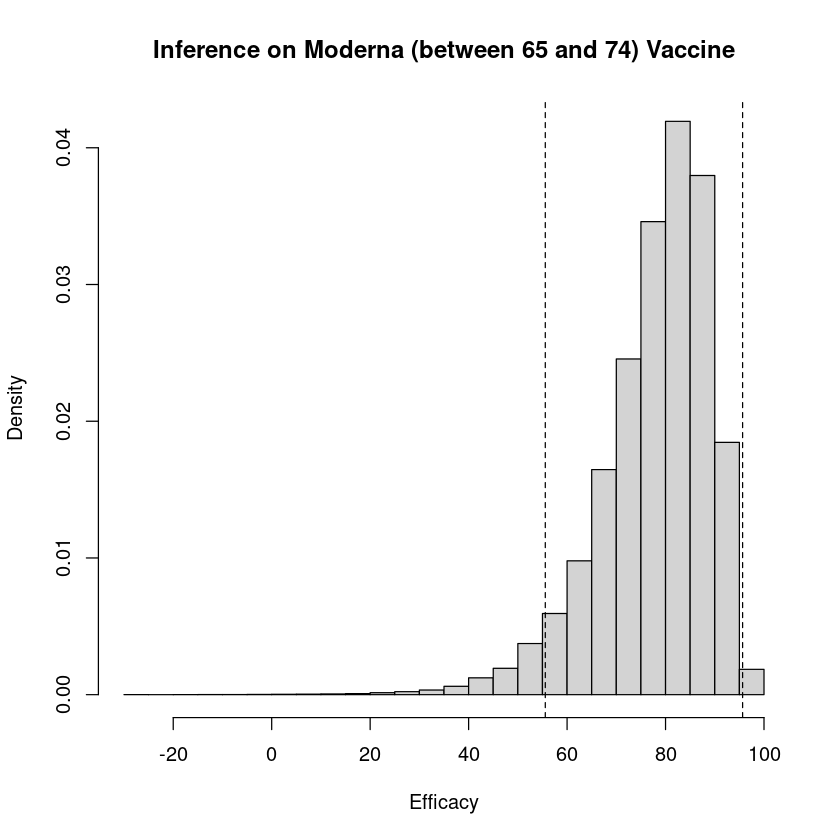

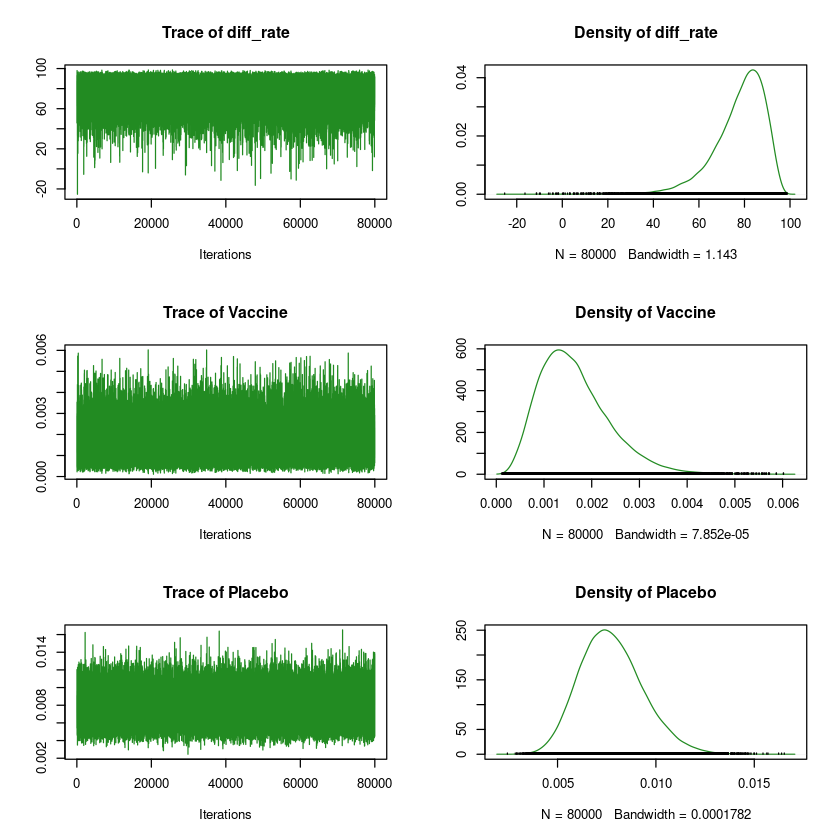

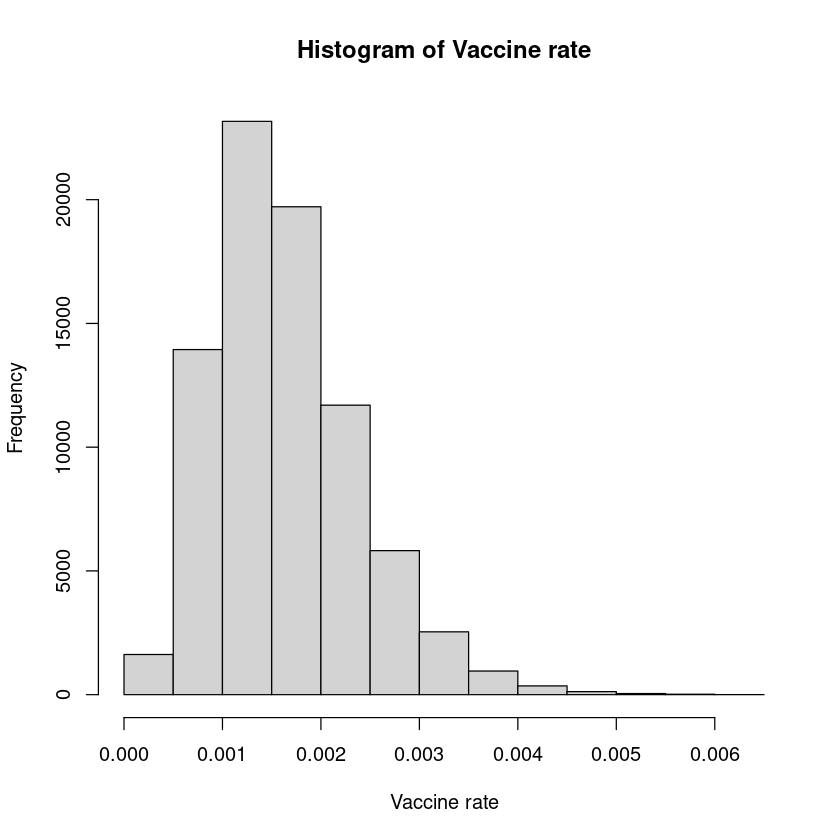

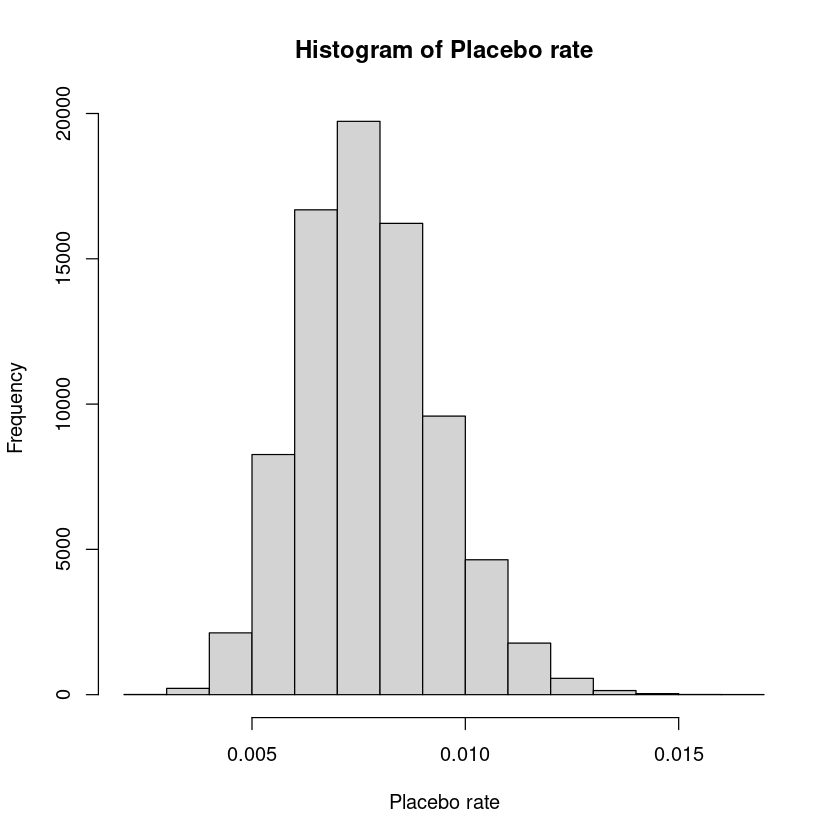

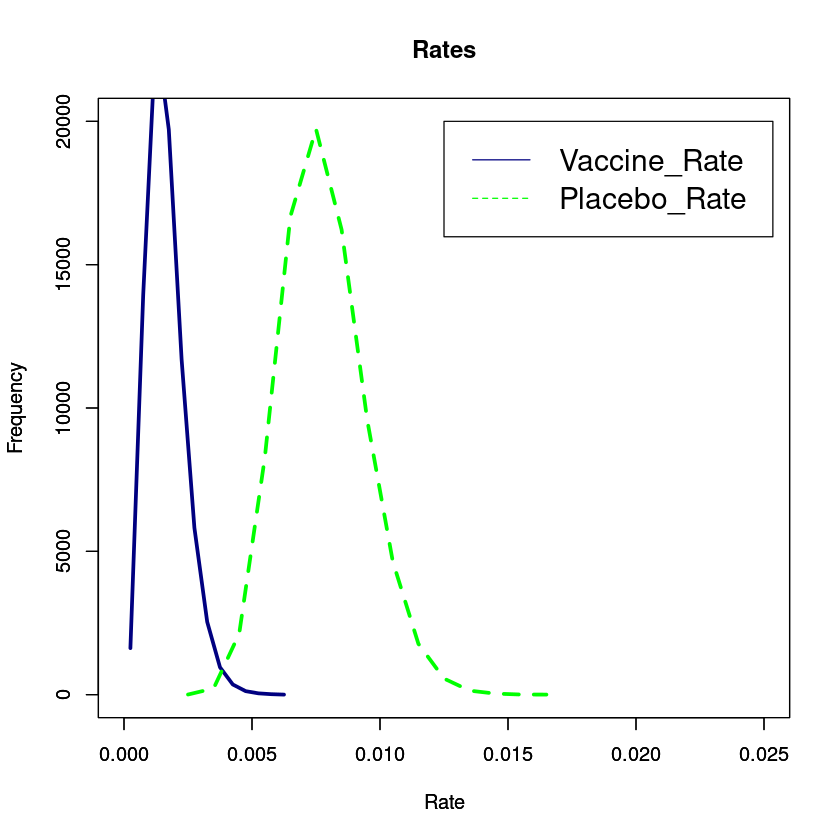

In [11]:
### between 65 and 74


tot_vaccine <- 2953
tot_placebo <- 2864
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 4
pos_placebo <- 22
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(1 , 100)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_elder_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (between 65 and 74) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

#pdf(file='Moderna(between 65 and 74)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (between 65 and 74) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()



#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
          Neg Pos
  Placebo 681   7
  Vaccine 630   0

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:09:06 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 1318
   Unobserved stochastic nodes: 2
   Total graph size: 2642
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not req

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],3.53958e-03,9.712645e-03,1.77800e-02,1.017059e-02,0.0038064056,NA,1.908336e-05,0.5,39785,0.001456843,1.000049
theta[2],5.61887e-311,1.589375e-33,5.18927e-06,1.518355e-05,0.0001586838,NA,8.250172e-07,0.5,36995,-0.002279271,1.000245


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                     
             Lower95     Median    Upper95       Mean         SD Mode
theta[1]   0.0033677  0.0097077   0.017666   0.010181  0.0038139   --
theta[2] 5.6189e-311 1.3905e-33 5.5089e-06 0.00001616 0.00016917   --
                                                    
               MCerr MC%ofSD SSeff      AC.10   psrf
theta[1] 0.000013489     0.4 79938  0.0014568 1.0001
theta[2]  6.1682e-07     0.4 75215 -0.0022793 1.0001

Total time taken: 2 seconds


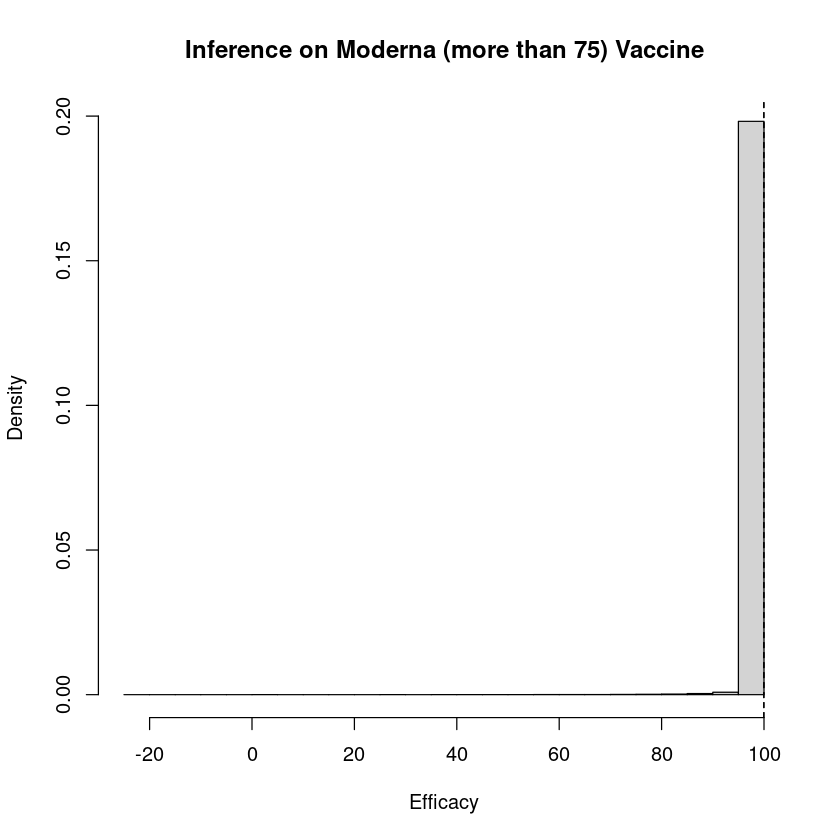

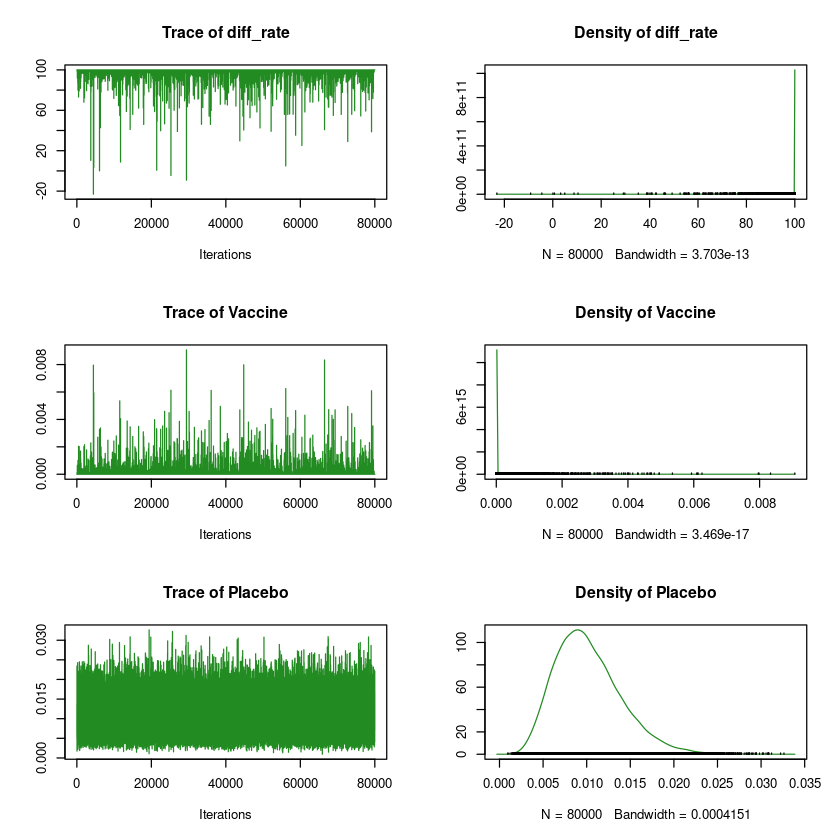

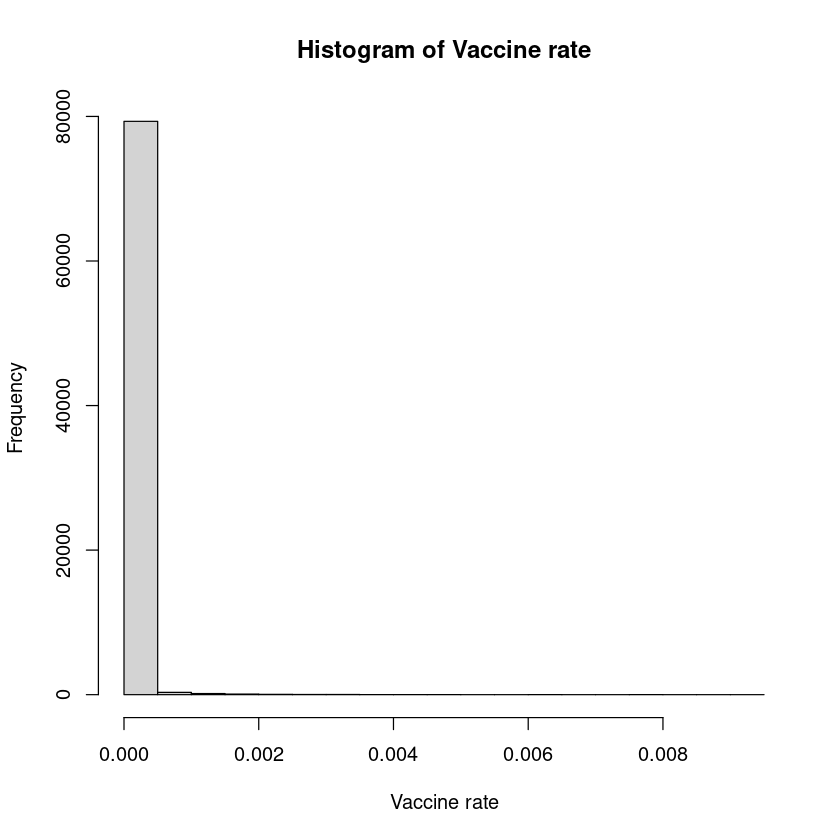

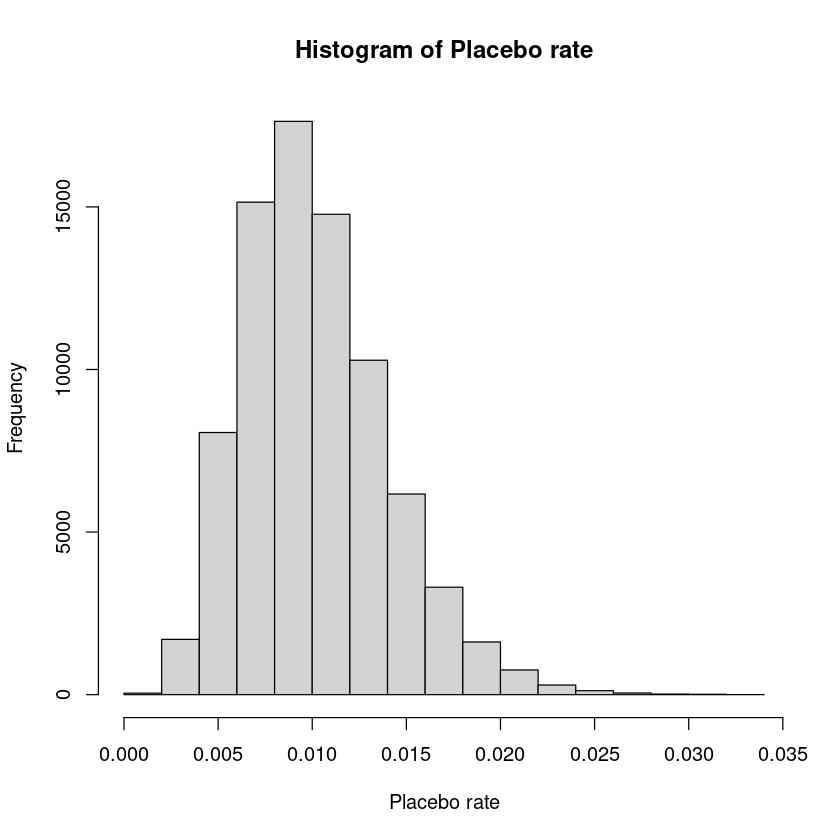

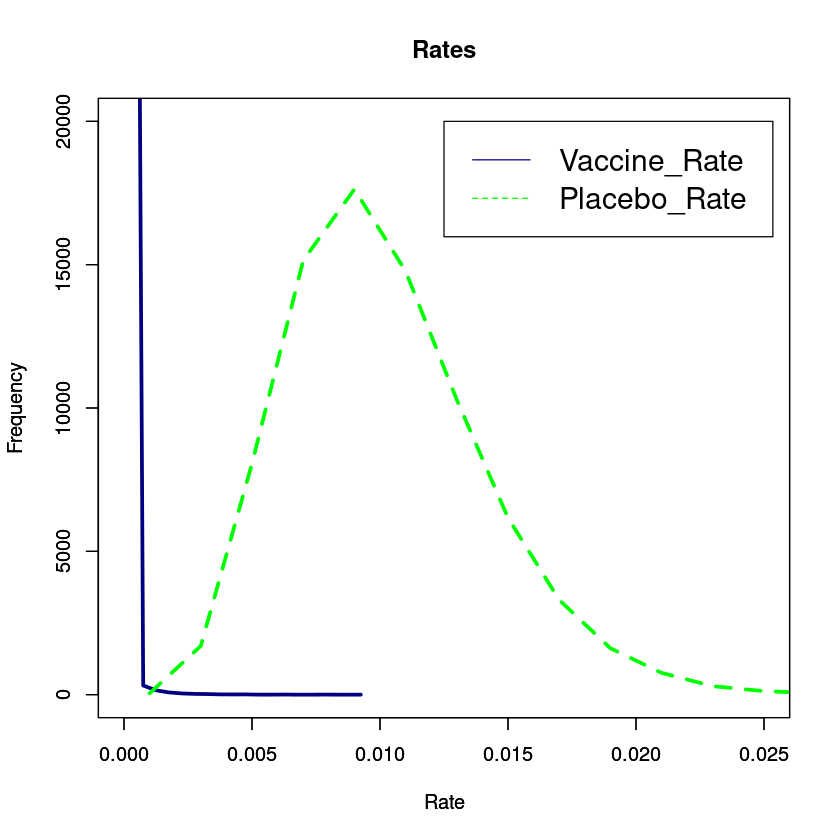

In [12]:
### more than 75


tot_vaccine <- 630
tot_placebo <- 688
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 0
pos_placebo <- 7
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (more than 75) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Moderna(more than 75)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Moderna (more than 75) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()



#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

### Astrazeneca

         
           Neg  Pos
  Placebo 5056  154
  Vaccine 5194   64

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:11:44 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 10468
   Unobserved stochastic nodes: 2
   Total graph size: 20942
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.02508630,0.0294939,0.0342910,0.02955325,0.00235361,NA,1.180997e-05,0.5,39717,0.002087392,1.0000380
theta[2],0.00929314,0.0121101,0.0152062,0.01217164,0.00151830,NA,7.616272e-06,0.5,39740,0.002826850,0.9999999


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                               
           Lower95   Median  Upper95     Mean        SD Mode      MCerr MC%ofSD
theta[1]  0.025069 0.029489  0.03426 0.029546 0.0023544   -- 8.3746e-06     0.4
theta[2] 0.0093065 0.012114 0.015217 0.012173 0.0015176   -- 5.3313e-06     0.4
                             
         SSeff     AC.10 psrf
theta[1] 79034 0.0020874    1
theta[2] 81035 0.0028268    1

Total time taken: 31.8 seconds


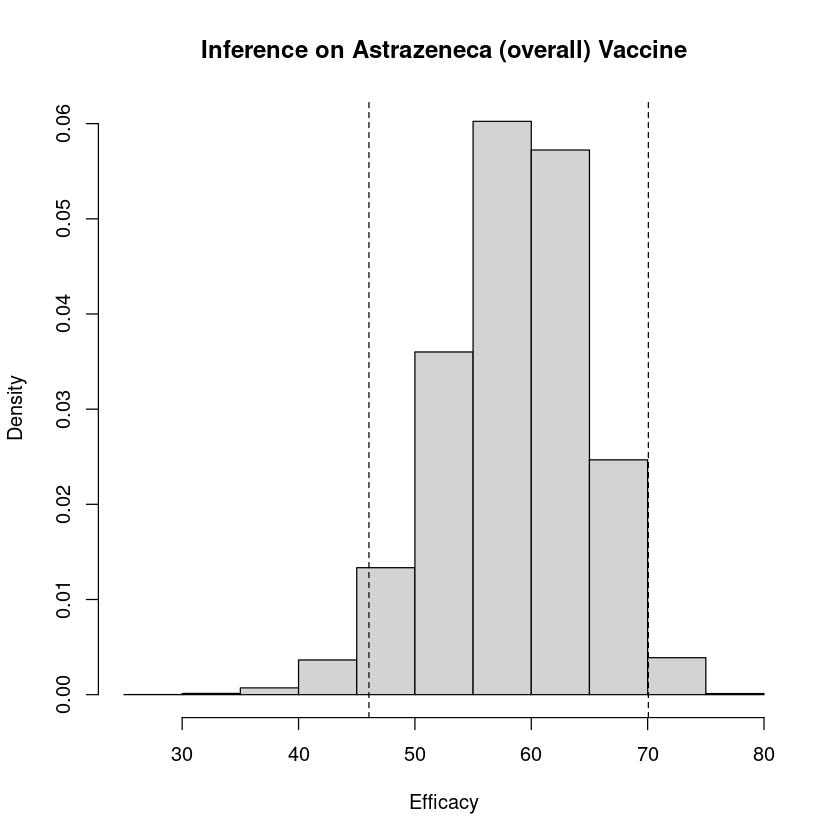

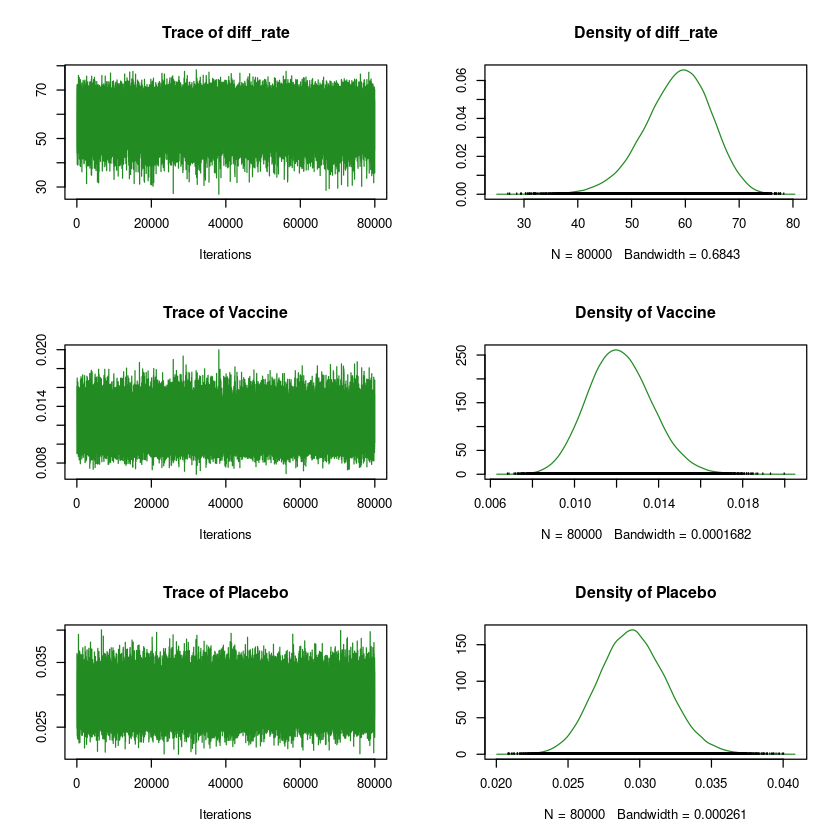

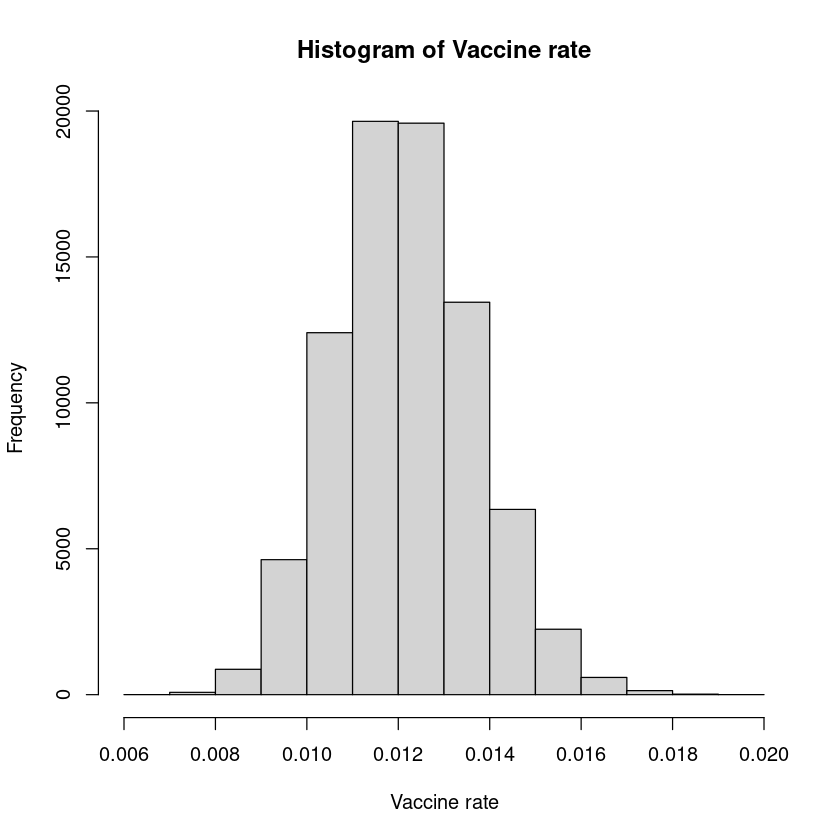

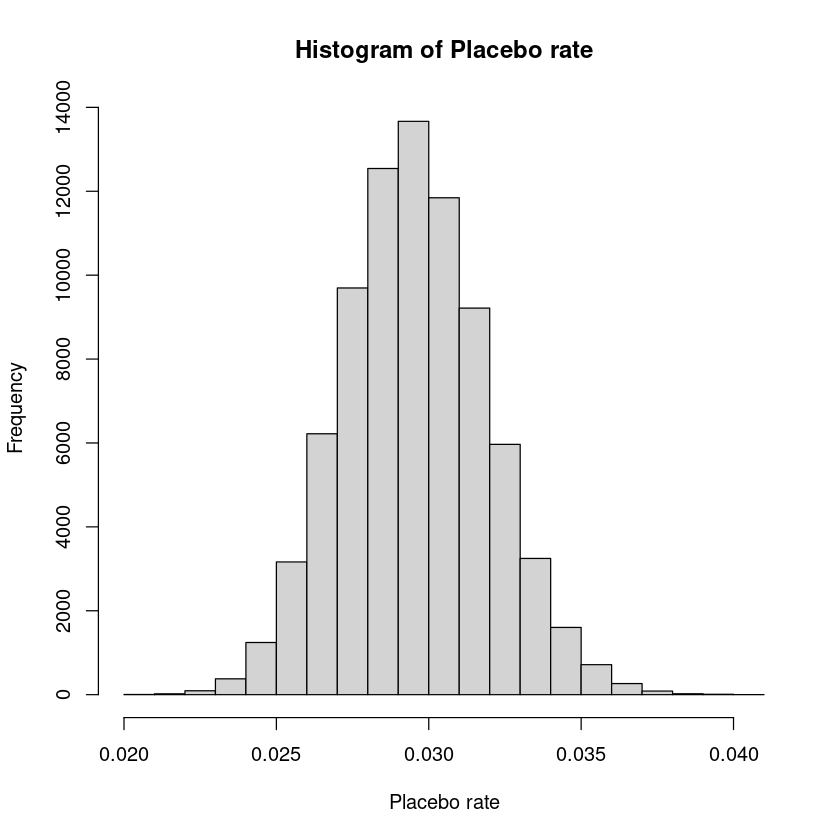

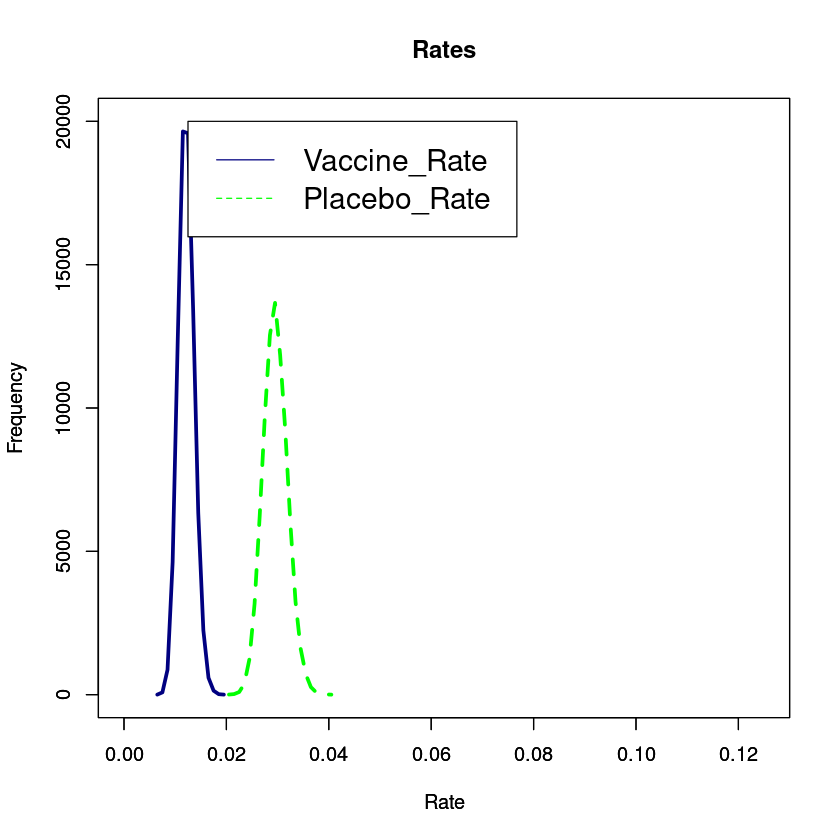

In [14]:
### overall


tot_vaccine <- 5258
tot_placebo <- 5210
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 64
pos_placebo <- 154
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Astrazeneca (overall) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Astrazeneca(overall)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Astrazeneca (overall) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.125),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.125),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

### Jonssen

         
            Neg   Pos
  Placebo 19343   348
  Vaccine 19514   116

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:13:19 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 39321
   Unobserved stochastic nodes: 2
   Total graph size: 78648
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01584110,0.017652700,0.01948700,0.017665483,0.0009320358,NA,4.660179e-06,0.5,40000,-0.001130909,1.0000847
theta[2],0.00483172,0.005891625,0.00694615,0.005907499,0.0005419684,NA,2.704833e-06,0.5,40148,-0.002769173,0.9999992


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.015835  0.017655  0.019489  0.017669 0.00093458   -- 3.3115e-06
theta[2] 0.0048673 0.0058905 0.0069921 0.0059087 0.00054659   -- 1.9457e-06
                                         
         MC%ofSD SSeff      AC.10    psrf
theta[1]     0.4 79647 -0.0011309       1
theta[2]     0.4 78918 -0.0027692 0.99999

Total time taken: 2.1 minutes


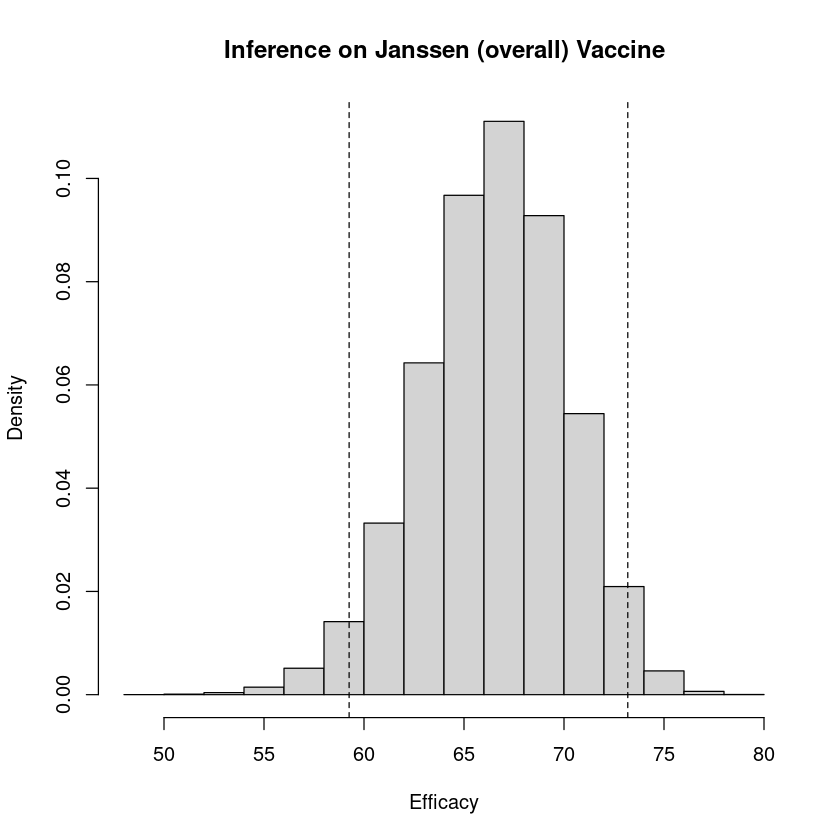

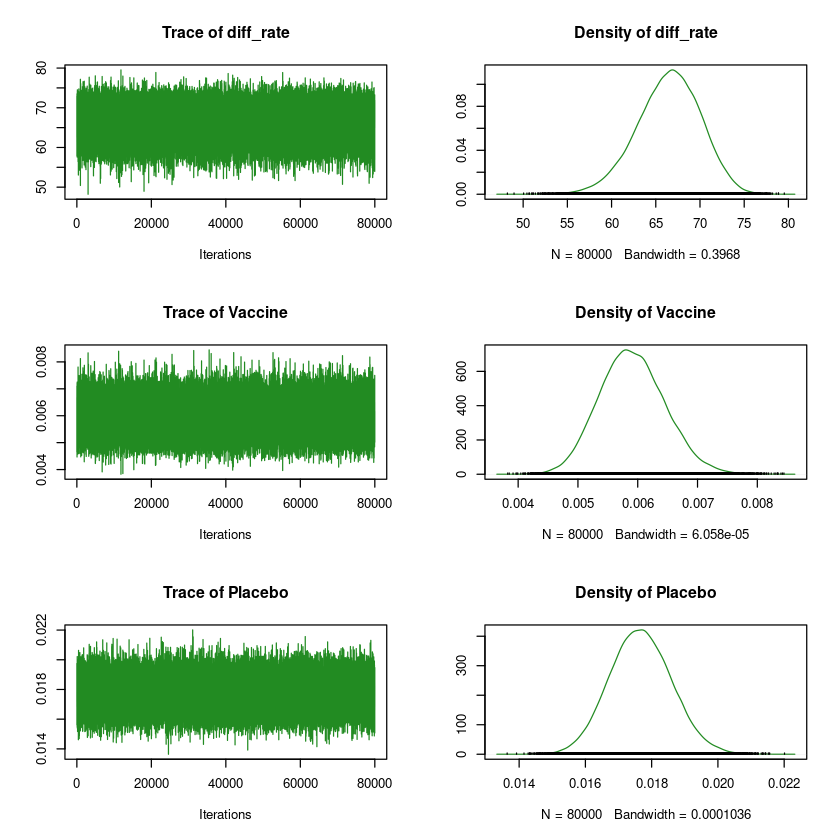

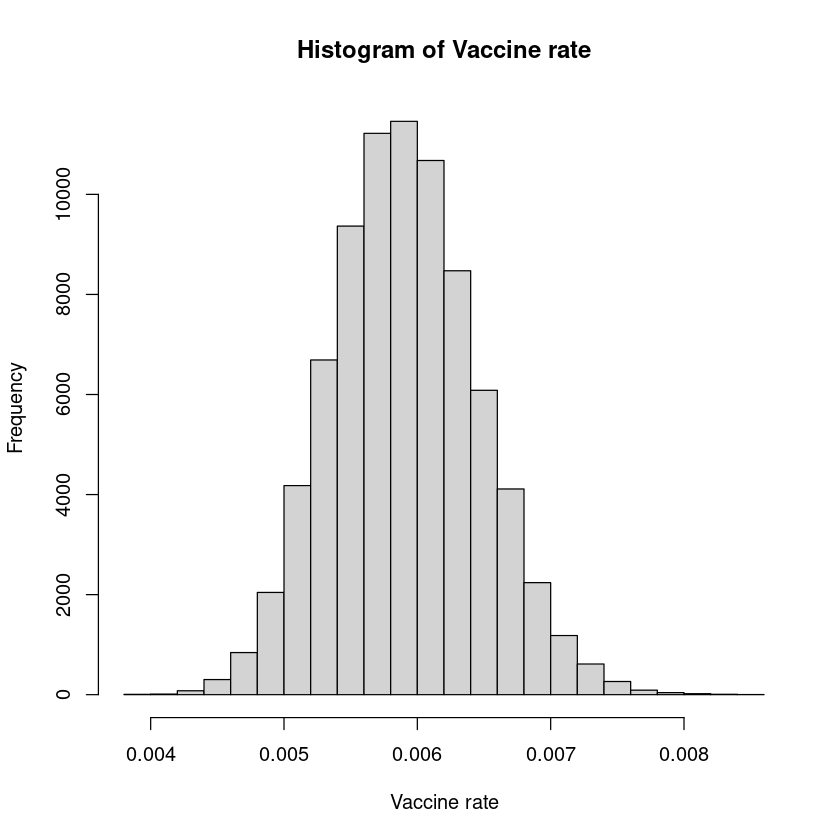

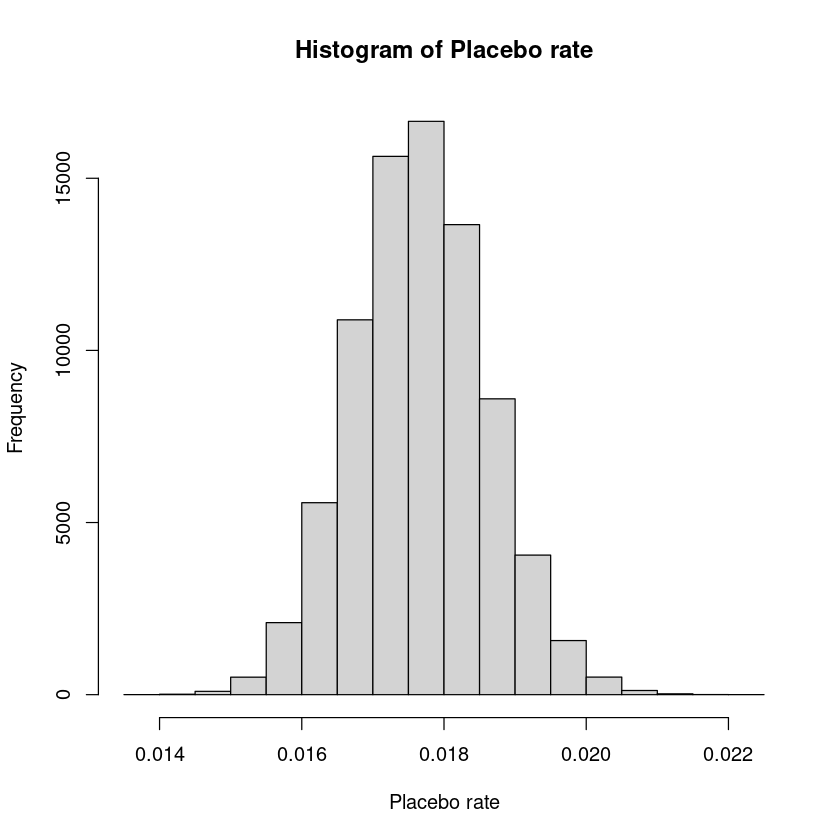

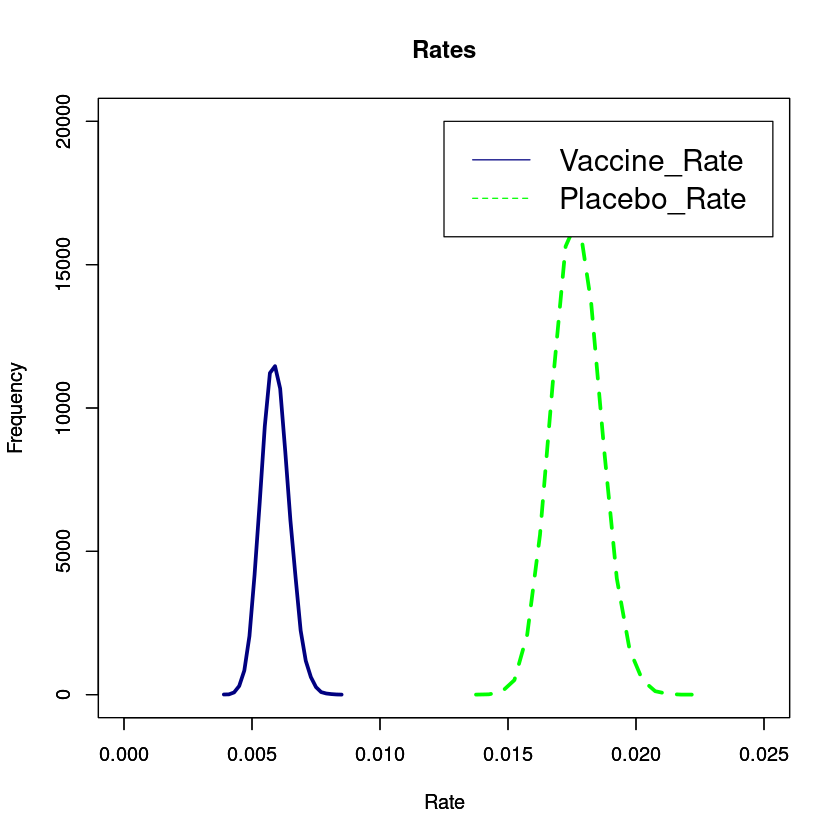

In [15]:
### overall


tot_vaccine <- 19630
tot_placebo <- 19691
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 116
pos_placebo <- 348
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (overall) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Janssen(overall)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (overall) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()



#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
            Neg   Pos
  Placebo 12621   260
  Vaccine 12735    95

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:16:13 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25711
   Unobserved stochastic nodes: 2
   Total graph size: 51428
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.0177753,0.020169550,0.02265630,0.02019168,0.0012430613,NA,6.247420e-06,0.5,39590,0.002512346,0.9999918
theta[2],0.0059233,0.007381695,0.00887564,0.00740686,0.0007556777,NA,3.764258e-06,0.5,40301,0.006864598,1.0000861


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.017777  0.020164  0.022612  0.020187  0.0012371   -- 4.3739e-06
theta[2] 0.0059669 0.0073812 0.0089046 0.0074045 0.00075316   -- 2.6653e-06
                                       
         MC%ofSD SSeff     AC.10   psrf
theta[1]     0.4 80000 0.0025123      1
theta[2]     0.4 79850 0.0068646 1.0001

Total time taken: 1.3 minutes


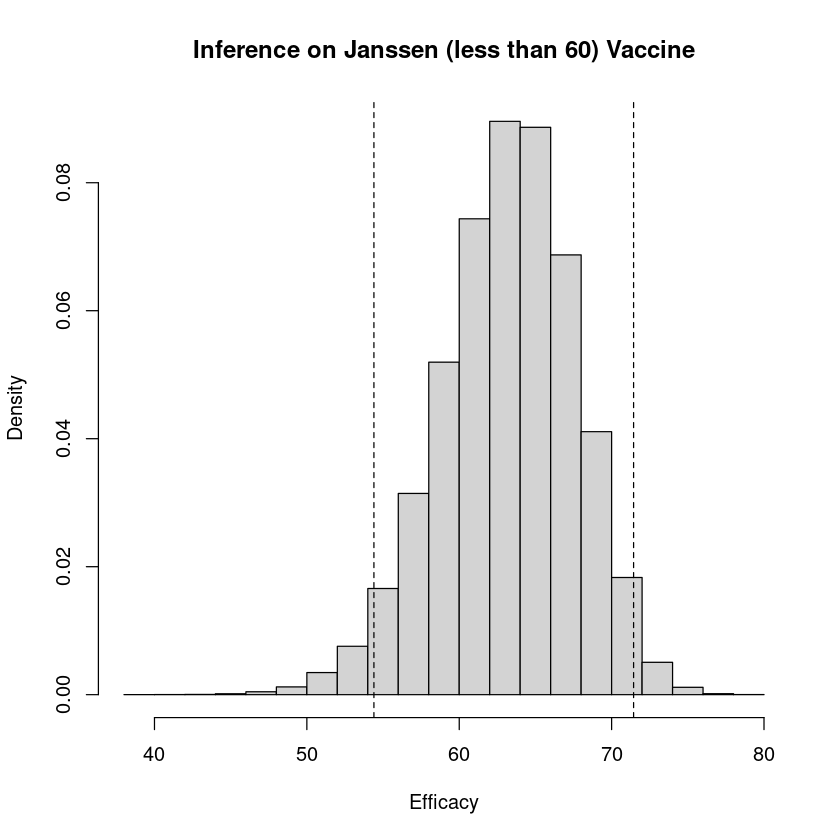

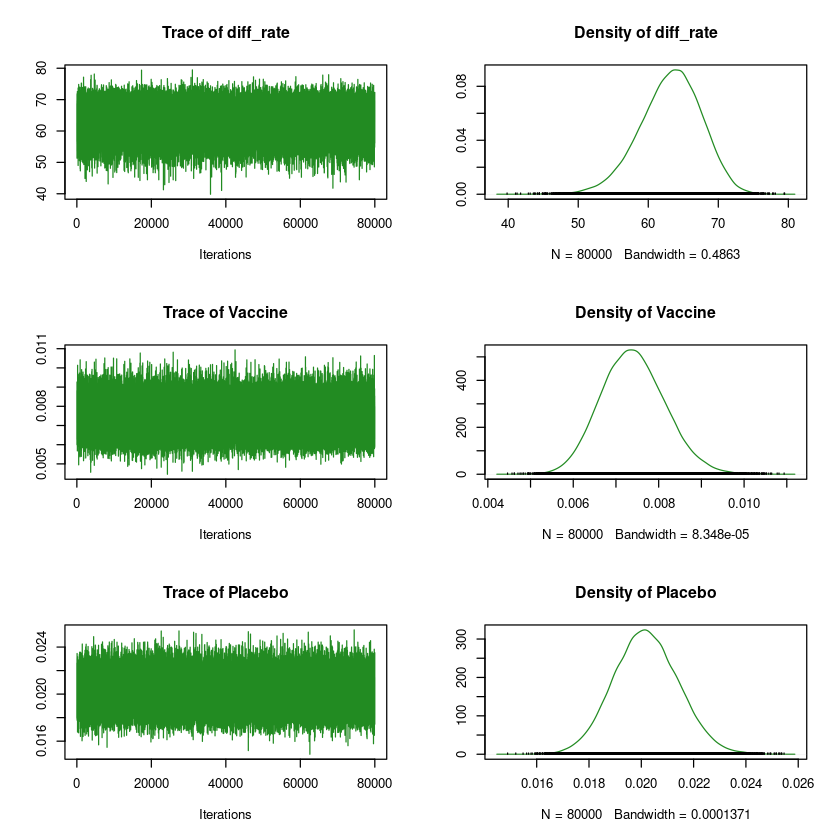

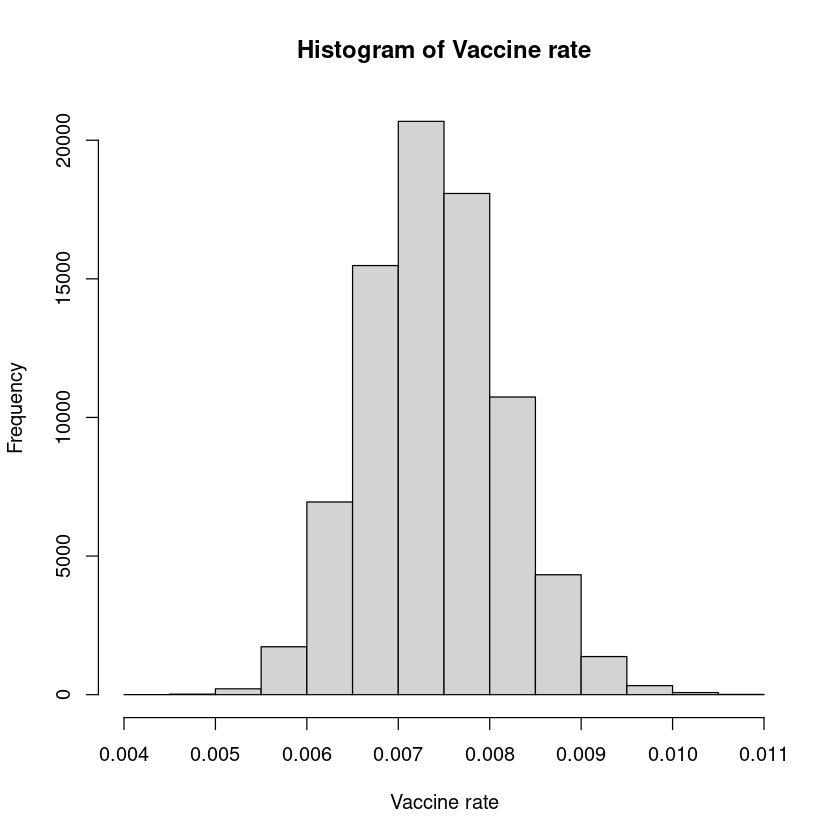

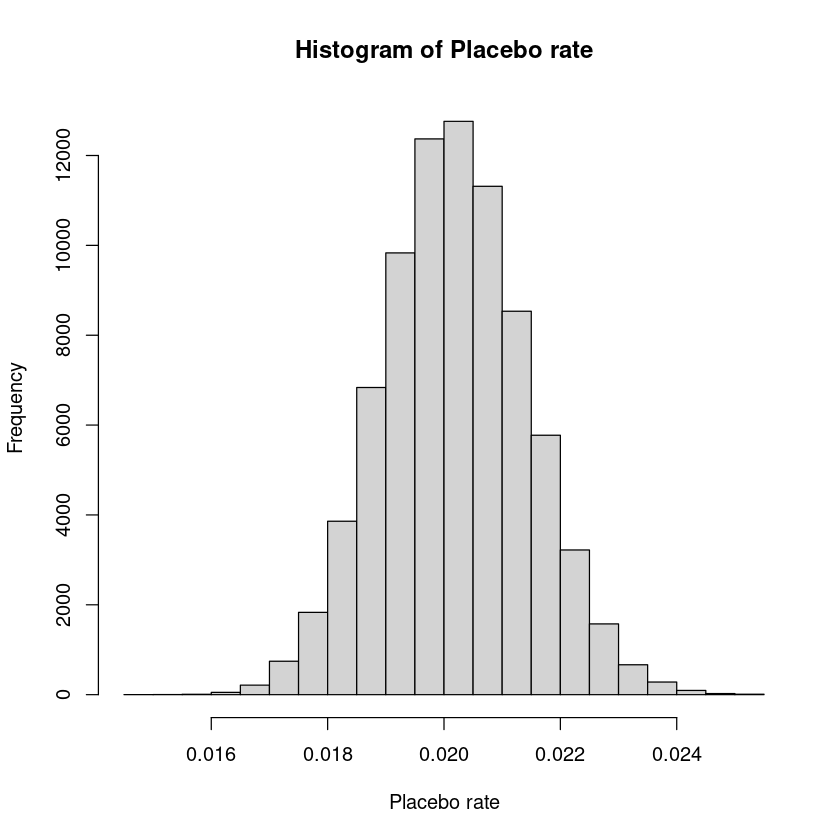

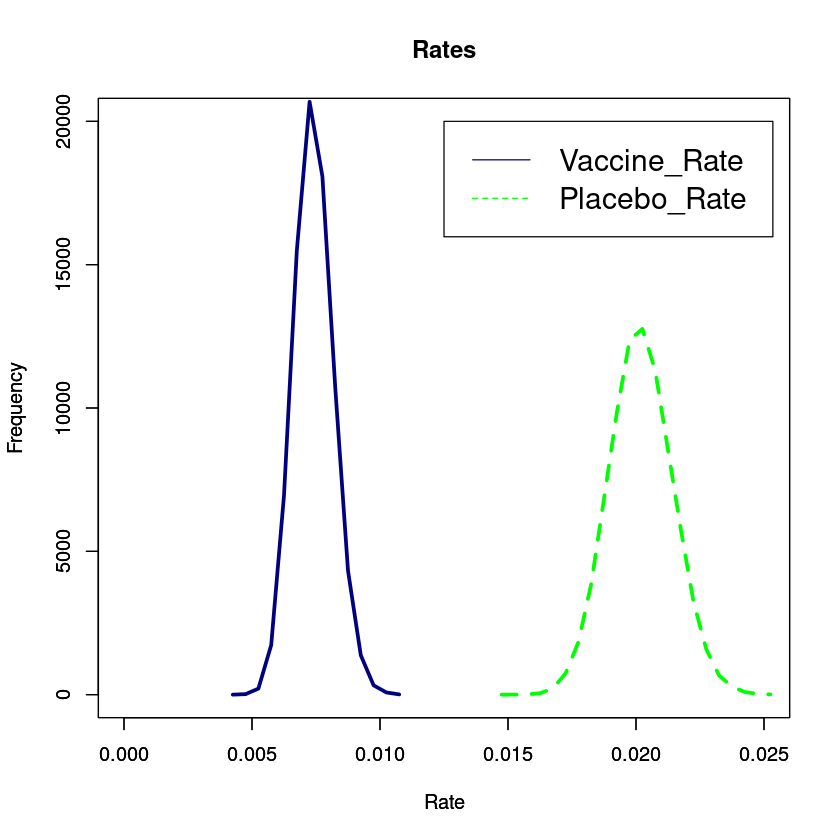

In [16]:
### less than 60


tot_vaccine <- 12830
tot_placebo <- 12881
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 95
pos_placebo <- 260
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (less than 60) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Janssen(less than 60)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (less than 60) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()



#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()

         
           Neg  Pos
  Placebo 6722   88
  Vaccine 6779   21

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Fri Jul  9 06:18:12 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 13610
   Unobserved stochastic nodes: 2
   Total graph size: 27226
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01024920,0.012880250,0.01558170,0.012933978,0.0013679589,NA,6.866417e-06,0.5,39690,0.005133068,1.000090
theta[2],0.00182003,0.003042085,0.00443349,0.003089418,0.0006778084,NA,3.428373e-06,0.5,39088,0.001585871,1.000018


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 2 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.010249  0.012877  0.015603  0.012928  0.0013677   -- 4.8005e-06
theta[2] 0.0018374 0.0030418 0.0044322 0.0030915 0.00067425   -- 2.3806e-06
                                       
         MC%ofSD SSeff     AC.10   psrf
theta[1]     0.4 81169 0.0051331 1.0001
theta[2]     0.4 80222 0.0015859 1.0001

Total time taken: 41.2 seconds


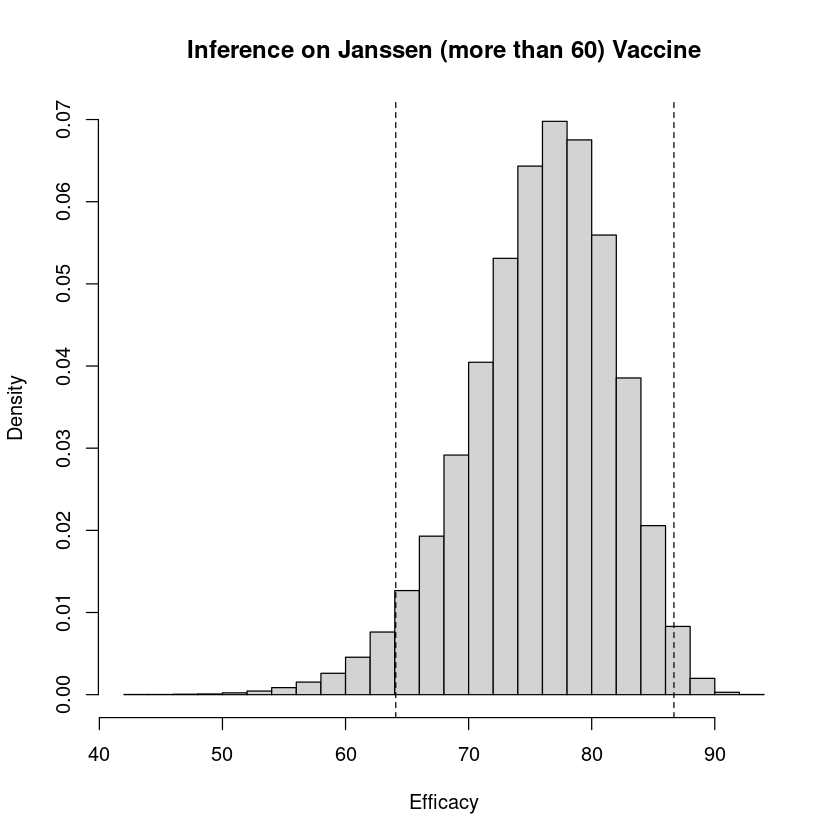

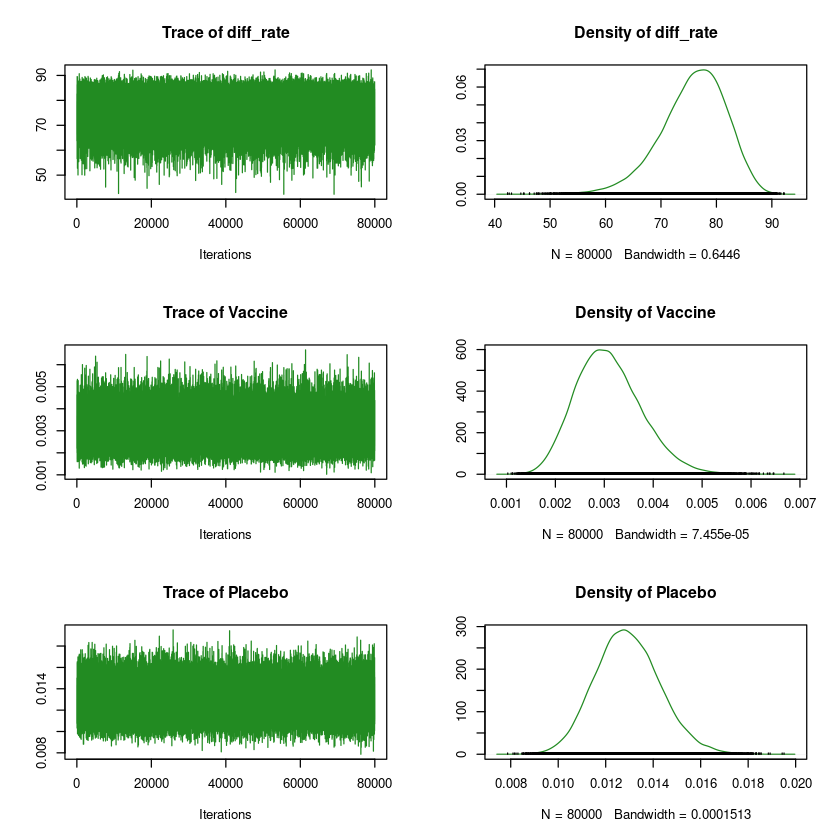

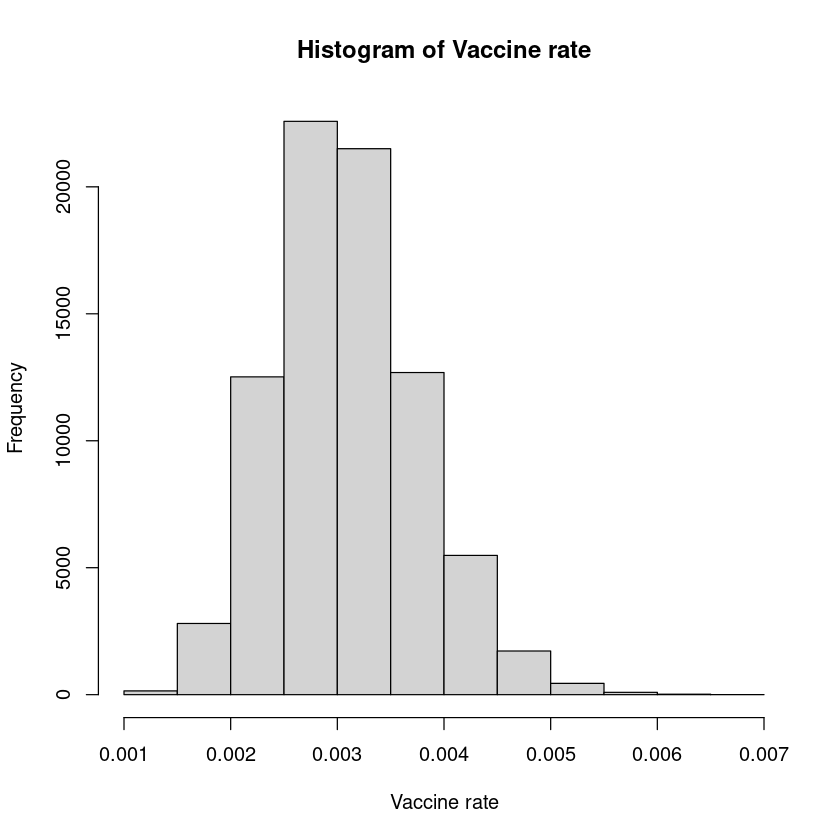

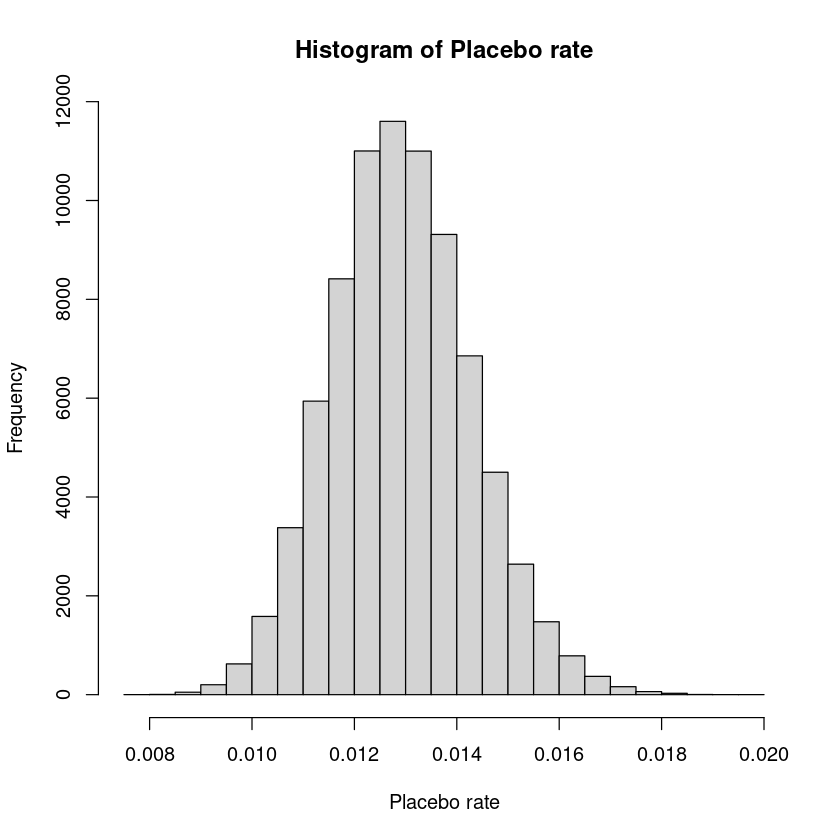

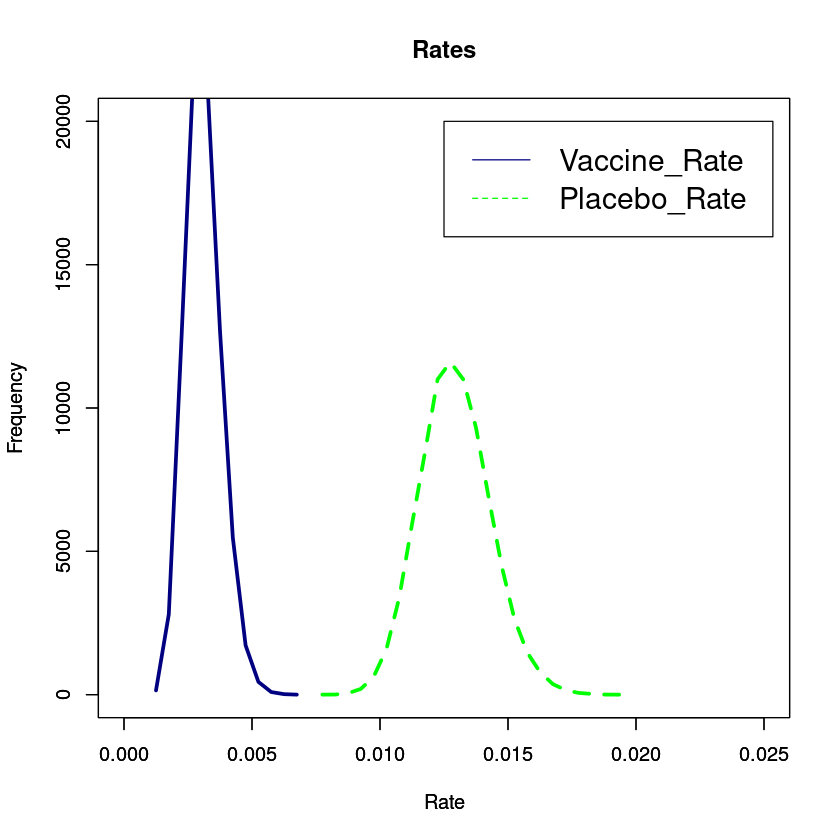

In [17]:
### more than 60


tot_vaccine <- 6800
tot_placebo <- 6810
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 21
pos_placebo <- 88
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
vaccine.tb <- tibble::tibble(tested = tested, patient=patient)
table(vaccine.tb[[2]], vaccine.tb[[1]])

dataList = list(
    tested = ifelse(vaccine.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(vaccine.tb$patient)),
    Ntot = nrow(vaccine.tb) ,
    Nclass = nlevels(factor(vaccine.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(0.010101 , 1)    
    }
  }"
writeLines(modelString , con="jags_Vaccine_model.txt")

vaccine_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(vaccine_chains)
add.summary(vaccine_chains)


### Efficacy

vaccine_res    <- tidybayes::tidy_draws(vaccine_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

vaccine.mcmc <- as.mcmc(vaccine_res)
vaccine.data <- as.data.frame(vaccine.mcmc)

#hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (more than 60) Vaccine')

tb = bayestestR::describe_posterior(vaccine.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")


#pdf(file='Janssen(more than 60)')
hist(vaccine.data$diff_rate,freq=FALSE,main='Inference on Janssen (more than 60) Vaccine',xlab='Efficacy')
abline(v=tb$CI_low,lty=2)
abline(v=tb$CI_high,lty=2)
#dev.off()


#pdf(file='Pfizer(overall)')
plot(vaccine.mcmc[,c('diff_rate','Vaccine','Placebo')],col='forestgreen')
#dev.off

h1 <- hist(vaccine.mcmc[,'Vaccine'],main='Histogram of Vaccine rate',xlab='Vaccine rate')
h2 <- hist(vaccine.mcmc[,'Placebo'],main='Histogram of Placebo rate',xlab='Placebo rate')

#pdf(file='Astrazeneca(Rate)')
plot(h1$mids,h1$counts,type='l',lwd=3,col='navy',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),main='Rates')
par(new=TRUE)
plot(h2$mids,h2$counts,type='l',lwd=3,col='green',
     xlab='Rate',ylab='Frequency',xlim=range(0,0.025),ylim=range(0,20000),lty=2)
legend(0.0125,20000,c('Vaccine_Rate','Placebo_Rate'), col=c('navy','green'),lty=1:2,cex=1.5)
#dev.off()